In [1]:
import pandas as pd
import os 

In [2]:
df = pd.read_csv("heart_disease_health_indicators_BRFSS2015.csv")
df = df.astype("int32")
df

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253676,0,1,1,1,18,0,0,2,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,0,1,28,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253678,0,1,0,1,23,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


In [3]:
# OG BMI
OG_BMI = df["BMI"]
# Relabel BMI based on CDC
    # 0 - Underweight
    # 1 - Healthy
    # 2 - Overweight
    # 3 - Obese
BMI_cat = []
for i in df["BMI"]:
    if i <= 19:
        BMI_cat.append(0)
    elif (i > 19) & (i < 25):
        BMI_cat.append(1)
    elif (i >= 25) & (i < 30):
        BMI_cat.append(2)
    else:
        BMI_cat.append(3)
df["BMI_cat"] = BMI_cat
# OG PhysHlth
OG_PhysHlth = df["PhysHlth"]
# Relabel PhysHlth
    # 0 - 0 days
    # 1 - At most 1 week
    # 2 - 1-2 weeks
    # 3 - 2-3 weeks
    # 4 - 3 weeks - 1 month
PhysHlth_cat = []
for i in df["PhysHlth"]:
    if i == 0:
        PhysHlth_cat.append(0)
    elif (i > 0) & (i <= 7):
        PhysHlth_cat.append(1)
    elif (i > 7) & (i <= 14):
        PhysHlth_cat.append(2)
    elif (i > 14) & (i <= 21):
        PhysHlth_cat.append(3)
    else:
        PhysHlth_cat.append(4)
df["PhysHlth_cat"] = PhysHlth_cat
# OG MentHlth
OG_MentHlth = df["MentHlth"]
# Relabel MentHlth
    # 0 - 0 days
    # 1 - At most 1 week
    # 2 - 1-2 weeks
    # 3 - 2-3 weeks
    # 4 - 3 weeks - 1 month
MentHlth_cat = []
for i in df["MentHlth"]:
    if i == 0:
        MentHlth_cat.append(0)
    elif (i > 0) & (i <= 7):
        MentHlth_cat.append(1)
    elif (i > 7) & (i <= 14):
        MentHlth_cat.append(2)
    elif (i > 14) & (i <= 21):
        MentHlth_cat.append(3)
    else:
        MentHlth_cat.append(4)
df["MentHlth_cat"] = MentHlth_cat
df = df.drop(columns=["BMI","PhysHlth","MentHlth"])

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
import numpy as np
import plotnine as p9
from concurrent.futures import ThreadPoolExecutor

In [6]:
def CE(df,B,df_xs=None,df_ys=None,distr=False):
    N = df.shape[0]
    # CE(Y)
    if type(df_xs) == type(None):
        ys_names = [col.name for col in df_ys]
        prob_Y = df[ys_names].value_counts()/N
        def CE_Y(b):
            rng = np.random.RandomState(b)
            new_freq_Y = rng.multinomial(N,prob_Y)
            new_prob_Y = new_freq_Y/N
            new_CE_Y = -np.log(new_prob_Y[new_prob_Y!=0]).T@new_prob_Y[new_prob_Y!=0]
            return new_CE_Y
        if __name__ == '__main__':
            with ThreadPoolExecutor() as executor:
                B_num_CE_Y = list(executor.map(CE_Y, range(B)))
        if distr == False:
            return np.array(B_num_CE_Y)
        else:
            B_num_CE_Y_df = pd.DataFrame({"CE_Y":B_num_CE_Y})
            B_num_plot = (
            p9.ggplot(B_num_CE_Y_df)+
                p9.geom_density(p9.aes(x="CE_Y"))
            )
            print(B_num_plot)
    # CE(Y|X)
    else:
        con_table = pd.crosstab(df_xs,df_ys,margins = True)
        prob_table = (con_table.T/con_table["All"]).T.iloc[:-1,:-1]
        prob_X_i = con_table.iloc[:-1,:]["All"]/N
        def CE_Y_X(b):
            rng = np.random.RandomState(b)
            new_n_X = rng.multinomial(N,prob_X_i)
            new_CE_Y_X_i = []
            for i in range(prob_table.shape[0]):
                prob_Y_X_i = prob_table.iloc[i,:]
                if new_n_X[i] != 0:
                    new_prob_Y_X_i = rng.multinomial(new_n_X[i],prob_Y_X_i)/new_n_X[i]
                    new_CE_Y_X_i.append(-np.log(new_prob_Y_X_i[new_prob_Y_X_i!=0]).T@new_prob_Y_X_i[new_prob_Y_X_i!=0])
                else:
                    new_CE_Y_X_i.append(0)
            new_prob_X = new_n_X/N
            new_CE_Y_X = new_prob_X.T@new_CE_Y_X_i
            return new_CE_Y_X
        if __name__ == '__main__':
            with ThreadPoolExecutor() as executor:
                B_num_CE_Y_X = list(executor.map(CE_Y_X, range(B)))
        if distr == False:
            return np.array(B_num_CE_Y_X)
        else:
            B_num_CE_Y_X_df = pd.DataFrame({"CE_Y_X":B_num_CE_Y_X})
            B_num_plot = (
            p9.ggplot(B_num_CE_Y_X_df)+
                p9.geom_density(p9.aes(x="CE_Y_X"))
            )
            print(B_num_plot)

In [7]:
def Info(df,B,df_xs,df_ys,distr=False):
    B_num_CE_Y = CE(df=df,B=B,df_ys=df_ys)
    B_num_CE_Y_X = CE(df=df,B=B,df_xs=df_xs,df_ys=df_ys)
    # Mean Info(X,Y)
    B_num_Info_X_and_Y = B_num_CE_Y - B_num_CE_Y_X
    if distr == False:
        return B_num_Info_X_and_Y
    else:
        # Info(X,Y) = CE(Y) - CE(Y|X) = CE(X) - CE(X|Y), which means we don't need to do both directions
        B_num_Info_X_and_Y_df = pd.DataFrame({"Info(X,Y)": B_num_Info_X_and_Y})  
        B_num_Info_X_and_Y_plot = (
            p9.ggplot(B_num_Info_X_and_Y_df)+
            p9.geom_density(p9.aes(x="Info(X,Y)"))
        )
        print(B_num_Info_X_and_Y_plot) 
        print("Mean Info(X,Y) = " + str(np.mean(B_num_Info_X_and_Y)))

In [8]:
import itertools

In [9]:
def sig_xs(df,B,xs,df_ys,predictor_type,sig_Info=0.01):
    if predictor_type == "one":
        xs = pd.Series(xs)
        Infos = pd.Series([np.mean(Info(df,B,[df[x]],df_ys)) for x in xs])
        sig_xs = pd.DataFrame([(i,j) for i,j in zip(xs,Infos) if j >= sig_Info], columns = ["xs","Infos"])
        sig_xs = sig_xs.sort_values(by=["Infos"],ascending=False).reset_index(drop=True)
        return sig_xs
    elif predictor_type == "two":
        x1_x2_all = []
        for combination in itertools.combinations(xs, 2):
            x1_x2_all.append(combination)
        x1_x2_all = pd.Series(x1_x2_all)
        def Infos_x1_x2(x1_x2):
            x1 = x1_x2[0]
            x2 = x1_x2[1]
            return np.mean(Info(df,B,[df[x1],df[x2]],df_ys))
        if __name__ == '__main__':
            with ThreadPoolExecutor() as executor:
                Infos = pd.Series(list(executor.map(Infos_x1_x2, x1_x2_all)))
        sig_x1_x2 = pd.DataFrame([(i,j) for i,j in zip(x1_x2_all,Infos) if j >= sig_Info], columns = ["x1_x2","Infos"])
        sig_x1_x2 = sig_x1_x2.sort_values(by=["Infos"],ascending=False).reset_index(drop=True)
        return sig_x1_x2
    elif predictor_type == "three":
        ys_xs = []
        for i in range(len(df_ys)):
            ys_xs.append(df_ys[i].name)
        for x in xs:
            ys_xs.append(x)
        x1_x2_x3_subset = [(xs[0],xs[1],i) for i in df.columns.drop(ys_xs)]
        def Infos_x1_x2_x3(x1_x2_x3):
            x1 = x1_x2_x3[0]
            x2 = x1_x2_x3[1]
            x3 = x1_x2_x3[2]
            return np.mean(Info(df,B,[df[x1],df[x2],df[x3]],df_ys))
        if __name__ == '__main__':
            with ThreadPoolExecutor() as executor:
                Infos = pd.Series(list(executor.map(Infos_x1_x2_x3, x1_x2_x3_subset)))
        sig_x1_x2_x3 = pd.DataFrame([(i,j) for i,j in zip(x1_x2_x3_subset,Infos)], columns = ["x1_x2_x3","Infos"])
        sig_x1_x2_x3 = sig_x1_x2_x3.sort_values(by=["Infos"],ascending=False).reset_index(drop=True)
        return sig_x1_x2_x3

In [10]:
def xs_vs_ys(df_xs,df_ys,ct=False,pt=True,px=False):
    con_table = pd.crosstab(df_xs,df_ys,margins = True)
    if ct == True:
        return(con_table)
    if pt == True:
        prob_table = (con_table.T/con_table["All"]).T.iloc[:-1,:-1]
        return(prob_table)
    if px == True:
        N = df.shape[0]
        prob_X_i = con_table.iloc[:-1,:]["All"]/N
        return(prob_X_i)

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

In [12]:
def clustering(g,df_xs,df_ys,dendo_plot=True,ids=False,figsize=(20, 20),fontsize=10,outliers=[]):
    if dendo_plot == True:
        linkage_matrix = g.dendrogram_col.linkage
        plt.figure(figsize=figsize)
        dendrogram = hierarchy.dendrogram(linkage_matrix, 
                                          labels = xs_vs_ys(df_xs,df_ys).drop(outliers,axis=0).index,
                                          leaf_font_size=fontsize)
        plt.show()
    if ids == True:
        if dendo_plot == False:
            linkage_matrix = g.dendrogram_col.linkage
            dendrogram = hierarchy.dendrogram(linkage_matrix, no_plot = True)
        tree = hierarchy.to_tree(linkage_matrix)
        directional_ids = []
        def traverse(node, path):
            if node.is_leaf():
                directional_id = ''.join(path)
                directional_ids.append(directional_id)
            else:
                traverse(node.left, path + ['0'])
                traverse(node.right, path + ['1'])
        traverse(tree, [])
        leaf_indices = dendrogram['leaves']
        directional_ids_df = pd.DataFrame({"x_groups":leaf_indices,
                                           "directional_ids":directional_ids}).sort_values(by="x_groups").reset_index(drop=True)
        directional_ids_df["x_groups"] = xs_vs_ys(df_xs,df_ys).drop(outliers,axis=0).index
        return directional_ids_df        

In [13]:
def common_branch_df(df,df_xs,df_ys,x_subgroups,y_subgroups,B,outliers=[]):
    N = df.shape[0]
    prob_X_i = xs_vs_ys(df_xs,df_ys,pt=False,px=True)
    prob_table = xs_vs_ys(df_xs,df_ys)
    def common_branch_info(b):
        new_con_table = pd.crosstab(df_xs,df_ys,margins = True)
        rng = np.random.RandomState(b)
        new_n_X = rng.multinomial(N,prob_X_i)
        new_con_table.loc[:,"All"][:-1] = new_n_X
        for i in range(prob_table.shape[0]):
            prob_Y_X_i = prob_table.iloc[i,:]
            new_con_table.iloc[i,:-1] = rng.multinomial(new_n_X[i],prob_Y_X_i)
        new_con_table.iloc[new_con_table.shape[0]-1,:] = new_con_table.iloc[:-1,:].apply(sum,axis=0)
        new_prob_table = (new_con_table.T/new_con_table["All"]).T.iloc[:-1,:-1]
        new_prob_table = new_prob_table.drop(outliers,axis=0)
        
        #For outlier diagnosis
        #print(new_prob_table)
        
        prob_y_x = [i[0] for i in new_prob_table.loc[x_subgroups,y_subgroups].values]
        mean_prob_y_x = np.mean(new_prob_table.loc[x_subgroups,y_subgroups]).iloc[0]
        max_prob_y_not_x = np.max(new_prob_table.loc[[i not in x_subgroups for i in new_prob_table.index],y_subgroups]).iloc[0]
        min_prob_y_not_x = np.min(new_prob_table.loc[[i not in x_subgroups for i in new_prob_table.index],y_subgroups]).iloc[0]
        
        return [prob_y_x,mean_prob_y_x,max_prob_y_not_x,min_prob_y_not_x] 
    if __name__ == '__main__':
        with ThreadPoolExecutor() as executor:
            common_branch_df = pd.DataFrame(executor.map(common_branch_info, range(B)),columns = ["prob_y_x","mean_prob_y_x","max_prob_y_not_x","min_prob_y_not_x"]) 
    return common_branch_df

In [14]:
def reliablity(x_subgroups,y_subgroups,cb_df,risk):
    mean_prob_y_x_og = np.mean(xs_vs_ys(df_xs,df_ys).loc[x_subgroups,y_subgroups]).iloc[0]
    within_margin = [(i > mean_prob_y_x_og-0.05) & (i < mean_prob_y_x_og+0.05) for i in cb_df.loc[:,"mean_prob_y_x"]]
    print("Mean probability of " +
          str(y_subgroups) +
          " with " +
          str(x_subgroups) +
          " is " +
          str(round(mean_prob_y_x_og,2)*100) +
          "%")
    if risk == "high":
        highest_risk = cb_df.loc[:,"mean_prob_y_x"] > cb_df.loc[:,"max_prob_y_not_x"]
        print(str(np.sum([i & j for i,j in zip(within_margin,highest_risk)])) +
              " out of 100 samples show that the cluster has highest risk of " +
              str(y_subgroups) + 
              " (at around " + 
              str(round(mean_prob_y_x_og,2)*100) +
              "%)")
    elif risk == "low":
        lowest_risk = cb_df.loc[:,"mean_prob_y_x"] < cb_df.loc[:,"min_prob_y_not_x"]
        print(str(np.sum([i & j for i,j in zip(within_margin,lowest_risk)])) +
              " out of 100 samples show that the cluster has lowest risk of " +
              str(y_subgroups) + 
              " (at around " + 
              str(round(mean_prob_y_x_og,2)*100) +
              "%)")

# Univariate HeartDiseaseorAttack

In [15]:
sig_xs_HD = sig_xs(df = df,
                   B = 100,
                   xs = df.columns.drop(["HeartDiseaseorAttack"]),
                   df_ys = [df["HeartDiseaseorAttack"]],
                   predictor_type = "one",
                   sig_Info = 0)
sig_xs_HD

,xs,Infos
0,GenHlth,0.032154
1,Age,0.028316
2,HighBP,0.021955
3,DiffWalk,0.017856
4,HighChol,0.016097
5,PhysHlth_cat,0.013326
6,Diabetes,0.013101
7,Stroke,0.012715
8,Income,0.010053
9,Smoker,0.006340


In [16]:
#This section display the probability table of HeartDiseaseorAttack for the TOP 10 variable from above.
#We will show an example, then comment out the other 9 variable to avoid repetition

xs_vs_ys(df_xs=[df["GenHlth"]],df_ys=[df["HeartDiseaseorAttack"]])

#xs_vs_ys(df_xs=[df["Age"]],df_ys=[df["HeartDiseaseorAttack"]])
#xs_vs_ys(df_xs=[df["HighBP"]],df_ys=[df["HeartDiseaseorAttack"]])
#xs_vs_ys(df_xs=[df["DiffWalk"]],df_ys=[df["HeartDiseaseorAttack"]])
#xs_vs_ys(df_xs=[df["HighChol"]],df_ys=[df["HeartDiseaseorAttack"]])
#xs_vs_ys(df_xs=[df["PhysHlth_cat"]],df_ys=[df["HeartDiseaseorAttack"]])
#xs_vs_ys(df_xs=[df["Diabetes"]],df_ys=[df["HeartDiseaseorAttack"]])
#xs_vs_ys(df_xs=[df["Stroke"]],df_ys=[df["HeartDiseaseorAttack"]])
#xs_vs_ys(df_xs=[df["Income"]],df_ys=[df["HeartDiseaseorAttack"]])
#xs_vs_ys(df_xs=[df["Smoker"]],df_ys=[df["HeartDiseaseorAttack"]])

HeartDiseaseorAttack,0,1
GenHlth,,
1,0.977571,0.022429
2,0.953662,0.046338
3,0.895381,0.104619
4,0.786886,0.213114
5,0.660045,0.339955


# Two-Way Interactions HeartDiseaseorAttack

In [17]:
sig_x1_x2_HD = sig_xs(df = df,
                      B = 100,
                      xs = df.columns.drop(["HeartDiseaseorAttack"]),
                      df_ys = [df["HeartDiseaseorAttack"]],
                      predictor_type = "two",
                      sig_Info = 0.032154)
sig_x1_x2_HD

,x1_x2,Infos
0,"(GenHlth, Age)",0.055576
1,"(HighBP, GenHlth)",0.042983
2,"(HighChol, GenHlth)",0.041405
3,"(DiffWalk, Age)",0.040792
4,"(Age, PhysHlth_cat)",0.040628
5,"(HighBP, Age)",0.039222
6,"(Stroke, GenHlth)",0.038767
7,"(Stroke, Age)",0.038042
8,"(HighChol, Age)",0.037250
9,"(Diabetes, Age)",0.036777


# GenHlth, Age vs HeartDiseaseorAttack

In [18]:
df_xs=[df["GenHlth"],df["Age"]]
df_ys=[df["HeartDiseaseorAttack"]]

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rcParams

Text(992.9999999999999, 0.5, 'HeartDiseaseorAttack')

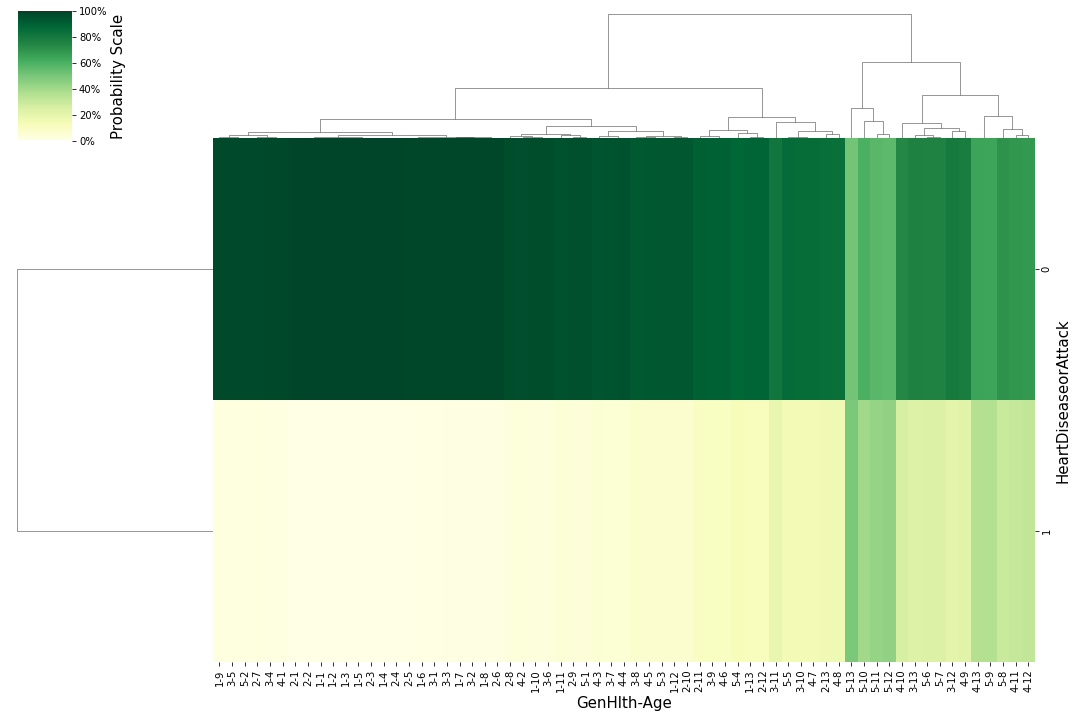

In [20]:
# Generate the cluster map
g = sns.clustermap(xs_vs_ys(df_xs, df_ys).T, cmap='YlGn', xticklabels=True, figsize=(15, 10))

# Get the colorbar associated with the plot
colorbar = g.ax_heatmap.collections[0].colorbar

# Create a formatter to convert values to percentage
formatter = mticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

# Set the font properties of the legend title
legend_title = 'Probability Scale'
colorbar.set_label(legend_title, fontsize=15)

# Set the formatter for the colorbar tick labels
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([formatter(tick) for tick in colorbar.get_ticks()])
g.ax_heatmap.set_xlabel('GenHlth-Age', fontsize=15)
g.ax_heatmap.set_ylabel('HeartDiseaseorAttack', fontsize=15)

In [22]:
x_subgroups=[(5,13),(5,12),(5,11),(5,10)]
y_subgroups=[1]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [1] with [(5, 13), (5, 12), (5, 11), (5, 10)] is 44.0%
100 out of 100 samples show that the cluster has highest risk of [1] (at around 44.0%)


In [23]:
## 1
# GenHlth
# Age

print(xs_vs_ys([df["GenHlth"]], [df["HeartDiseaseorAttack"]]).loc[[(5)],(1)].mean())
print(xs_vs_ys([df["Age"]], [df["HeartDiseaseorAttack"]]).loc[[(13),(12),(11),(10)],(1)].mean())

0.3399553017134343
0.18276259106970352


# GenHlth, Stroke vs HeartDiseaseorAttack

In [24]:
df_xs=[df["Stroke"],df["GenHlth"]]
df_ys=[df["HeartDiseaseorAttack"]]

Text(992.9999999999999, 0.5, 'HeartDiseaseorAttack')

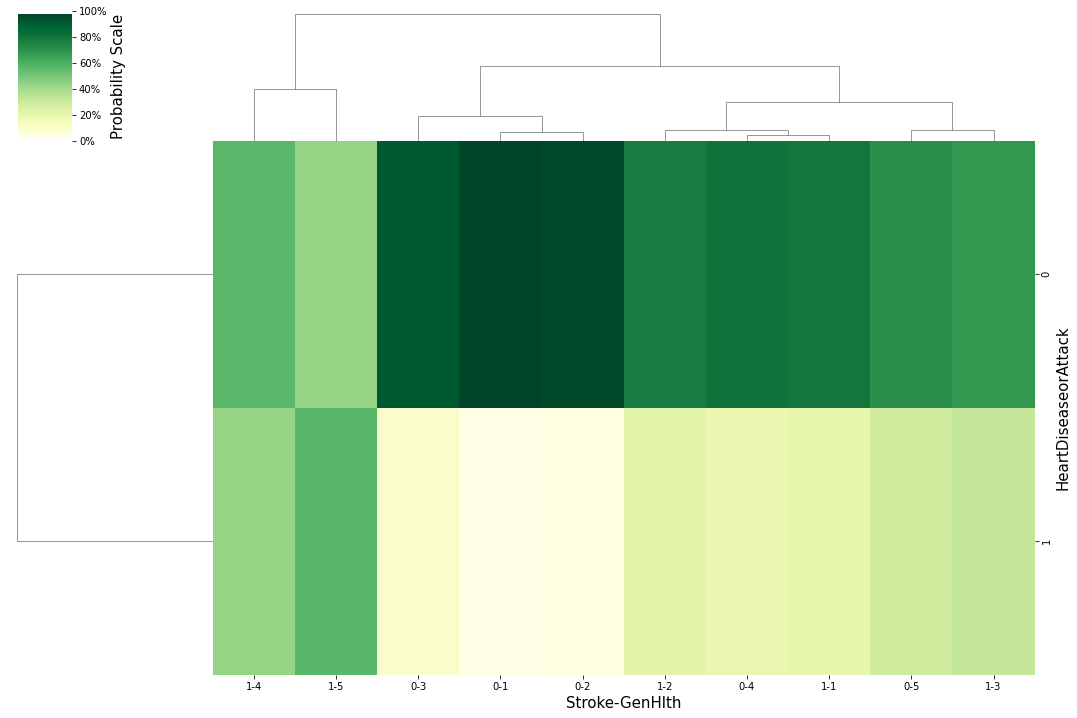

In [25]:
# Generate the cluster map
g = sns.clustermap(xs_vs_ys(df_xs, df_ys).T, cmap='YlGn', xticklabels=True, figsize=(15, 10))

# Get the colorbar associated with the plot
colorbar = g.ax_heatmap.collections[0].colorbar

# Create a formatter to convert values to percentage
formatter = mticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

# Set the font properties of the legend title
legend_title = 'Probability Scale'
colorbar.set_label(legend_title, fontsize=15)

# Set the formatter for the colorbar tick labels
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([formatter(tick) for tick in colorbar.get_ticks()])
g.ax_heatmap.set_xlabel('Stroke-GenHlth', fontsize=15)
g.ax_heatmap.set_ylabel('HeartDiseaseorAttack', fontsize=15)

In [27]:
x_subgroups=[(1,5),(1,4)]
y_subgroups=[1]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [1] with [(1, 5), (1, 4)] is 50.0%
100 out of 100 samples show that the cluster has highest risk of [1] (at around 50.0%)


In [28]:
x_subgroups=[(1,5)]
y_subgroups=[1]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [1] with [(1, 5)] is 56.99999999999999%
100 out of 100 samples show that the cluster has highest risk of [1] (at around 56.99999999999999%)


In [29]:
## 1
# GenHlth
# Stroke

print(xs_vs_ys([df["GenHlth"]], [df["HeartDiseaseorAttack"]]).loc[[(5)],(1)].mean())
print(xs_vs_ys([df["Stroke"]], [df["HeartDiseaseorAttack"]]).loc[[(1)],(1)].mean())

0.3399553017134343
0.3825301204819277


# Three-Way Interactions HeartDiseaseorAttack

In [30]:
GenHlth_Age_sig_x1_x2_x3_HD = sig_xs(df = df,
                                     B = 100,
                                     xs = ("GenHlth","Age"),
                                     df_ys = [df["HeartDiseaseorAttack"]],
                                     predictor_type = "three",
                                     sig_Info = 0)
GenHlth_Age_sig_x1_x2_x3_HD

,x1_x2_x3,Infos
0,"(GenHlth, Age, Sex)",0.061253
1,"(GenHlth, Age, HighChol)",0.060751
2,"(GenHlth, Age, Stroke)",0.060676
3,"(GenHlth, Age, HighBP)",0.060244
4,"(GenHlth, Age, Diabetes)",0.058151
5,"(GenHlth, Age, Income)",0.057995
6,"(GenHlth, Age, Smoker)",0.057876
7,"(GenHlth, Age, DiffWalk)",0.057292
8,"(GenHlth, Age, BMI_cat)",0.057164
9,"(GenHlth, Age, Education)",0.057116


# GenHlth, Age, HighBP vs HeartDiseaseorAttack

In [31]:
df_xs = [df["GenHlth"],df["Age"],df["HighBP"]]
df_ys = [df["HeartDiseaseorAttack"]]

In [32]:
small_group_size = 20
xs_vs_ys_ct_df = xs_vs_ys(df_xs,df_ys,ct=True)
outliers = xs_vs_ys_ct_df.index[xs_vs_ys_ct_df["All"] < small_group_size]

Text(1640.9999999999998, 0.5, 'HeartDiseaseorAttack')

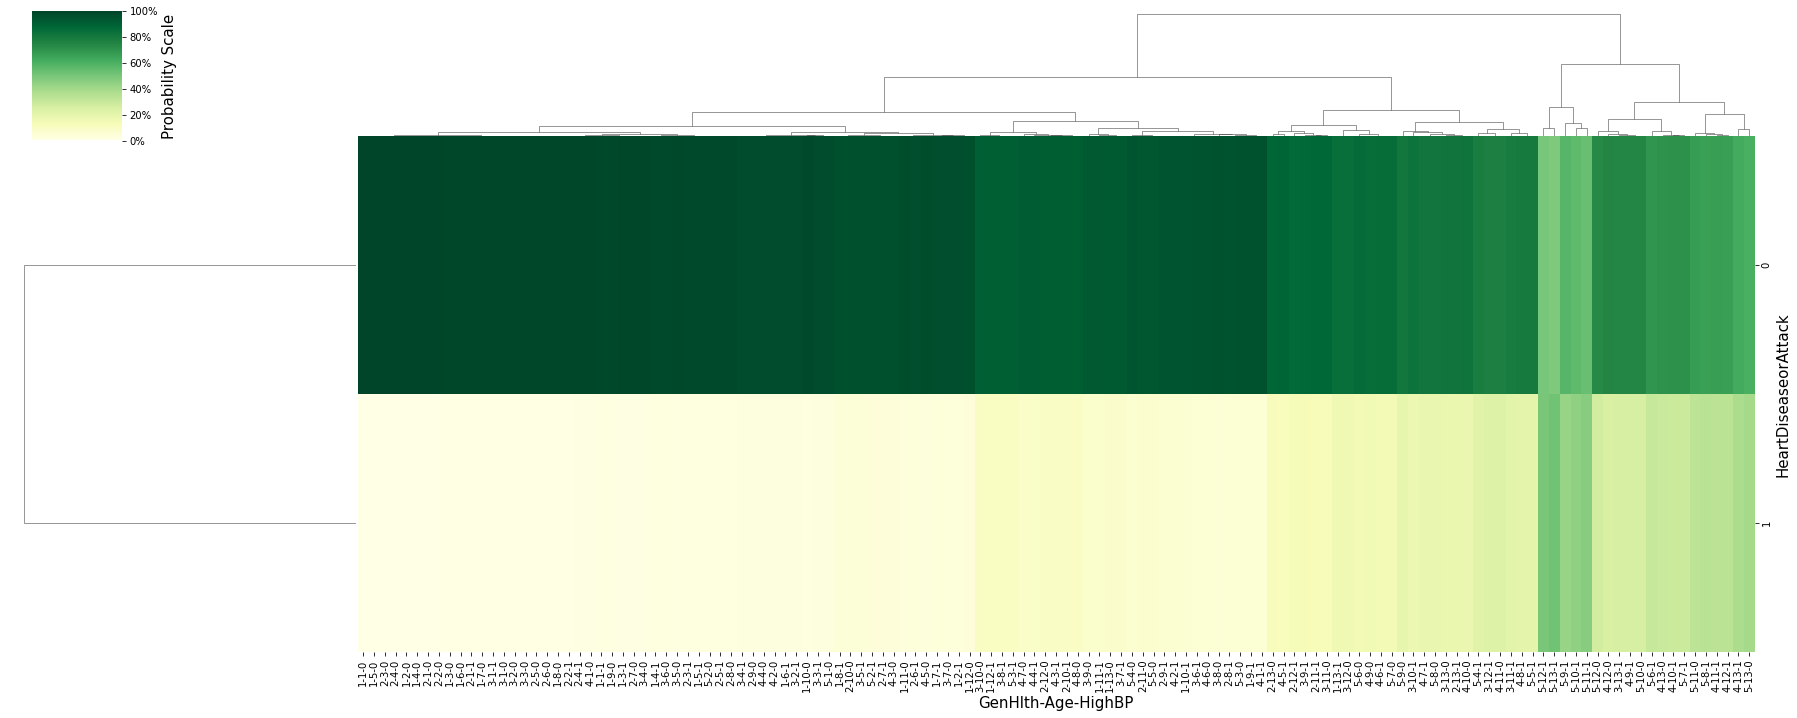

In [33]:
# Generate the cluster map
g = sns.clustermap(xs_vs_ys(df_xs, df_ys).drop(outliers,axis=0).T, cmap='YlGn', xticklabels=True, figsize=(25, 10))

# Get the colorbar associated with the plot
colorbar = g.ax_heatmap.collections[0].colorbar

# Create a formatter to convert values to percentage
formatter = mticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

# Set the font properties of the legend title
legend_title = 'Probability Scale'
colorbar.set_label(legend_title, fontsize=15)

# Set the formatter for the colorbar tick labels
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([formatter(tick) for tick in colorbar.get_ticks()])
g.ax_heatmap.set_xlabel('GenHlth-Age-HighBP', fontsize=15)
g.ax_heatmap.set_ylabel('HeartDiseaseorAttack', fontsize=15)

In [34]:
x_subgroups=[(5,12,1),(5,13,1)]
y_subgroups=[1]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100,
                         outliers=outliers)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [1] with [(5, 12, 1), (5, 13, 1)] is 51.0%
99 out of 100 samples show that the cluster has highest risk of [1] (at around 51.0%)


In [35]:
## 1
# GenHlth, Age, HighBP
    #GenHlth, Age
    #GenHlth, HighBP
    #Age, HighBP
print(xs_vs_ys([df["GenHlth"], df["Age"]], [df["HeartDiseaseorAttack"]]).loc[[(5,13),(5,12)],(1)].mean())
print(xs_vs_ys([df["GenHlth"], df["HighBP"]], [df["HeartDiseaseorAttack"]]).loc[[(5,1)],(1)].mean())
print(xs_vs_ys([df["Age"], df["HighBP"]], [df["HeartDiseaseorAttack"]]).loc[[(12,1),(13,1)],(1)].mean())

0.46475765933752883
0.40183902555529016
0.2534077124086385


# GenHlth, Age, HighChol vs HeartDiseaseorAttack

In [36]:
df_xs = [df["GenHlth"],df["Age"],df["HighChol"]]
df_ys = [df["HeartDiseaseorAttack"]]

In [37]:
small_group_size = 20
xs_vs_ys_ct_df = xs_vs_ys(df_xs,df_ys,ct=True)
outliers = xs_vs_ys_ct_df.index[xs_vs_ys_ct_df["All"] < small_group_size]

Text(1640.9999999999998, 0.5, 'HeartDiseaseorAttack')

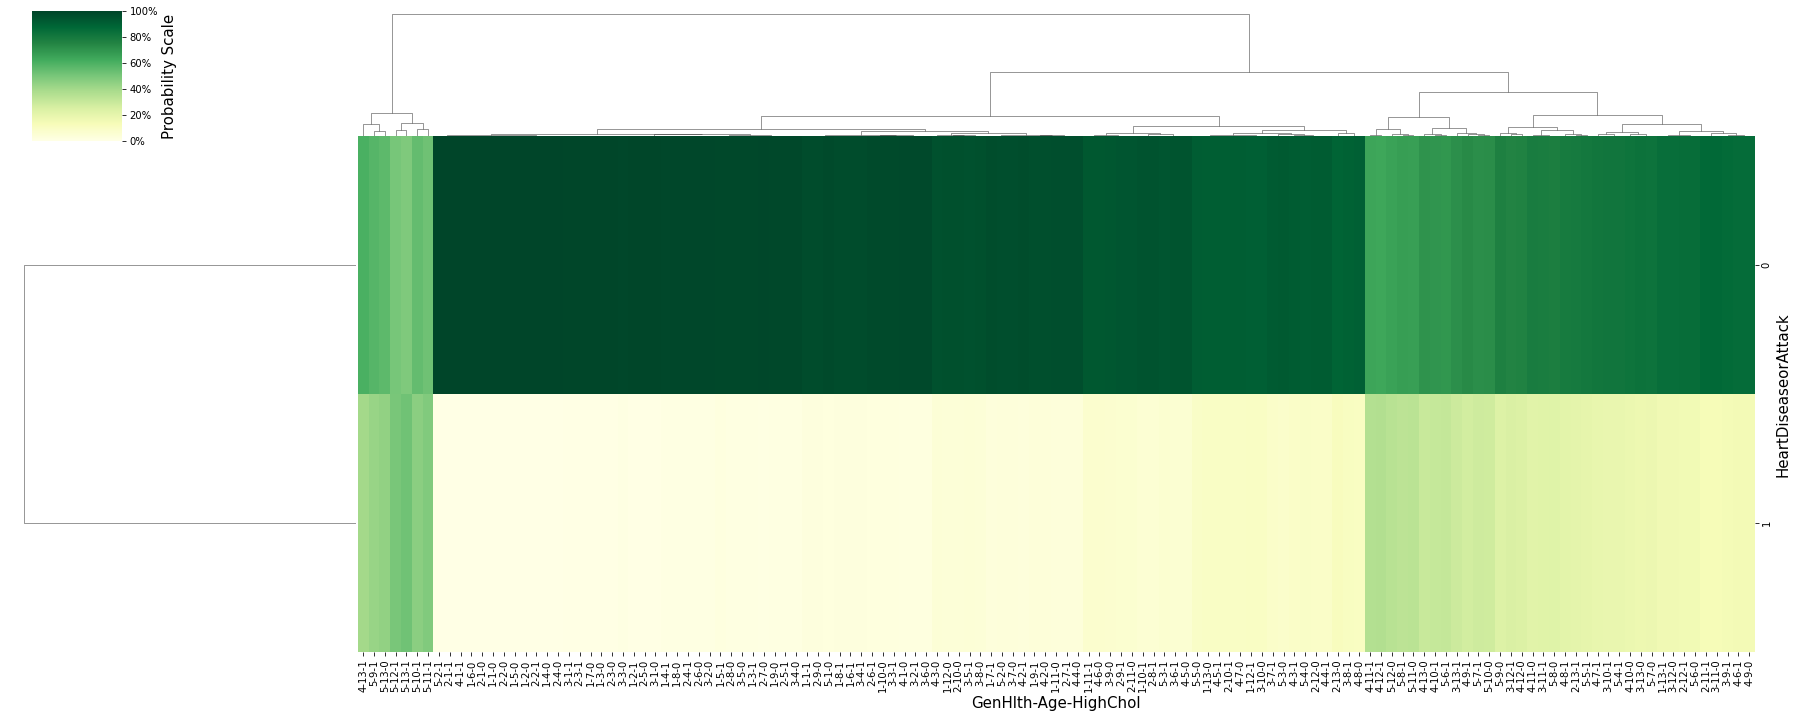

In [38]:
# Generate the cluster map
g = sns.clustermap(xs_vs_ys(df_xs, df_ys).drop(outliers,axis=0).T, cmap='YlGn', xticklabels=True, figsize=(25, 10))

# Get the colorbar associated with the plot
colorbar = g.ax_heatmap.collections[0].colorbar

# Create a formatter to convert values to percentage
formatter = mticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

# Set the font properties of the legend title
legend_title = 'Probability Scale'
colorbar.set_label(legend_title, fontsize=15)

# Set the formatter for the colorbar tick labels
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([formatter(tick) for tick in colorbar.get_ticks()])
g.ax_heatmap.set_xlabel('GenHlth-Age-HighChol', fontsize=15)
g.ax_heatmap.set_ylabel('HeartDiseaseorAttack', fontsize=15)

In [39]:
x_subgroups=[(5,12,1),(5,13,1)]
y_subgroups=[1]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100,
                         outliers=outliers)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [1] with [(5, 12, 1), (5, 13, 1)] is 51.0%
95 out of 100 samples show that the cluster has highest risk of [1] (at around 51.0%)


In [40]:
## 1
# GenHlth, Age, HighChol
    #GenHlth, Age
    #GenHlth, HighChol
    #Age, HighChol
print(xs_vs_ys([df["GenHlth"], df["Age"]], [df["HeartDiseaseorAttack"]]).loc[[(5,13),(5,12)],(1)].mean())
print(xs_vs_ys([df["GenHlth"], df["HighChol"]], [df["HeartDiseaseorAttack"]]).loc[[(5,1)],(1)].mean())
print(xs_vs_ys([df["Age"], df["HighChol"]], [df["HeartDiseaseorAttack"]]).loc[[(13,1),(12,1)],(1)].mean())

0.46475765933752883
0.39925571504518875
0.2689072607850141


# GenHlth, Age, Sex vs HeartDiseaseorAttack

In [41]:
df_xs = [df["GenHlth"],df["Age"],df["Sex"]]
df_ys = [df["HeartDiseaseorAttack"]]

Text(1640.9999999999998, 0.5, 'HeartDiseaseorAttack')

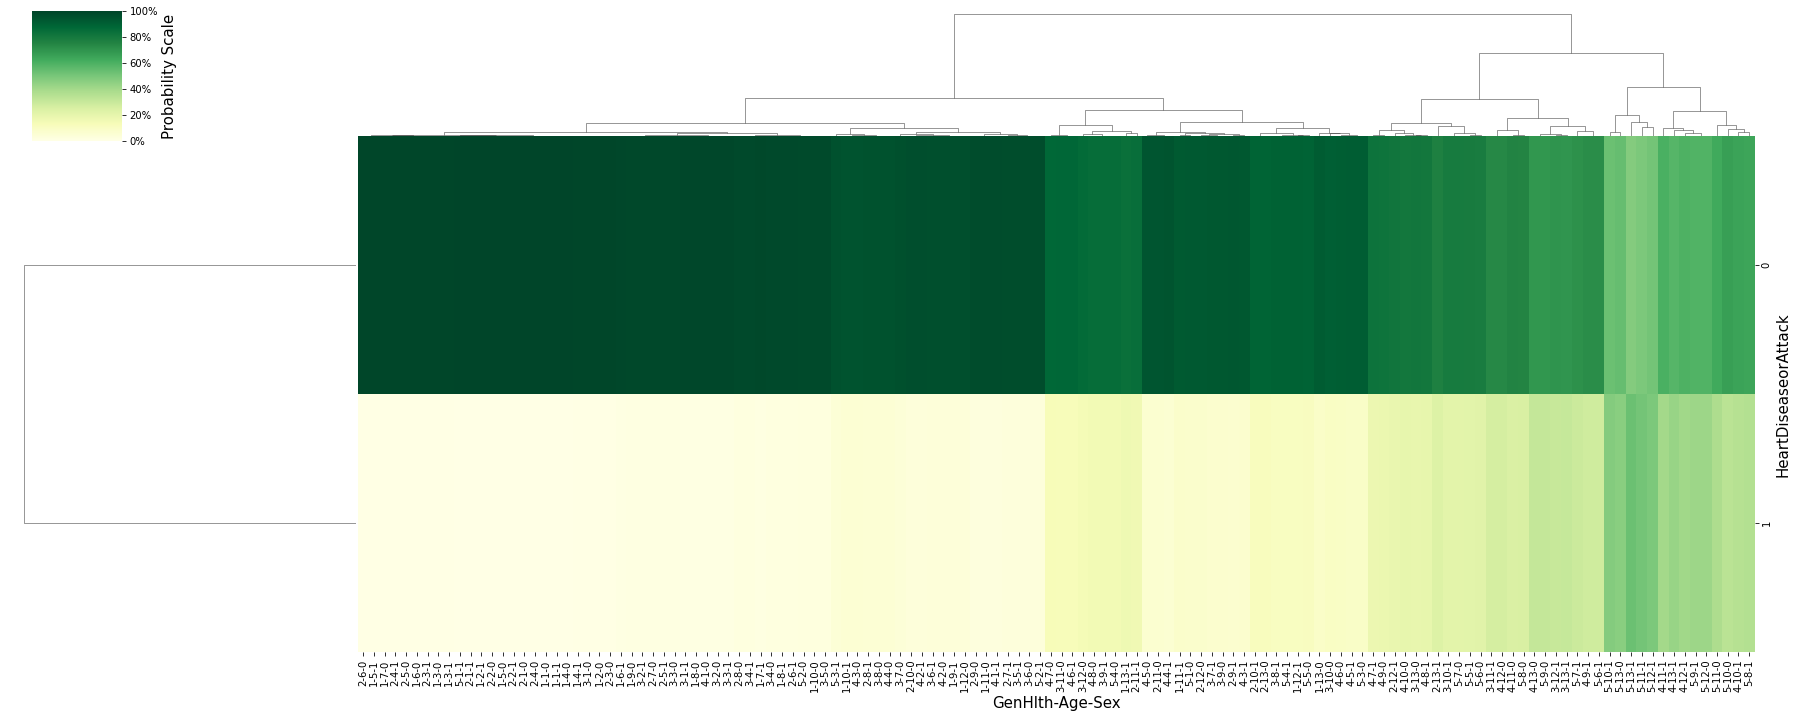

In [42]:
# Generate the cluster map
g = sns.clustermap(xs_vs_ys(df_xs, df_ys).T, cmap='YlGn', xticklabels=True, figsize=(25, 10))

# Get the colorbar associated with the plot
colorbar = g.ax_heatmap.collections[0].colorbar

# Create a formatter to convert values to percentage
formatter = mticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

# Set the font properties of the legend title
legend_title = 'Probability Scale'
colorbar.set_label(legend_title, fontsize=15)

# Set the formatter for the colorbar tick labels
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([formatter(tick) for tick in colorbar.get_ticks()])
g.ax_heatmap.set_xlabel('GenHlth-Age-Sex', fontsize=15)
g.ax_heatmap.set_ylabel('HeartDiseaseorAttack', fontsize=15)

In [43]:
x_subgroups=[(5,11,1),(5,12,1),(5,13,1)]
y_subgroups=[1]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [1] with [(5, 11, 1), (5, 12, 1), (5, 13, 1)] is 51.0%
91 out of 100 samples show that the cluster has highest risk of [1] (at around 51.0%)


In [44]:
## 1
# GenHlth, Age, Sex
    #GenHlth, Age
    #GenHlth, Sex
    #Age, Sex
print(xs_vs_ys([df["GenHlth"], df["Age"]], [df["HeartDiseaseorAttack"]]).loc[[(5,13),(5,12),(5,11)],(1)].mean())
print(xs_vs_ys([df["GenHlth"], df["Sex"]], [df["HeartDiseaseorAttack"]]).loc[[(5,1)],(1)].mean())
print(xs_vs_ys([df["Age"], df["Sex"]], [df["HeartDiseaseorAttack"]]).loc[[(13,1),(12,1),(11,1)],(1)].mean())

0.45380835629216937
0.39740566037735847
0.26748265587018144


# GenHlth, Age, Stroke vs HeartDiseaseorAttack

In [45]:
df_xs = [df["GenHlth"],df["Age"],df["Stroke"]]
df_ys = [df["HeartDiseaseorAttack"]]

In [46]:
small_group_size = 20
xs_vs_ys_ct_df = xs_vs_ys(df_xs,df_ys,ct=True)
outliers = xs_vs_ys_ct_df.index[xs_vs_ys_ct_df["All"] < small_group_size]

Text(1640.9999999999998, 0.5, 'HeartDiseaseorAttack')

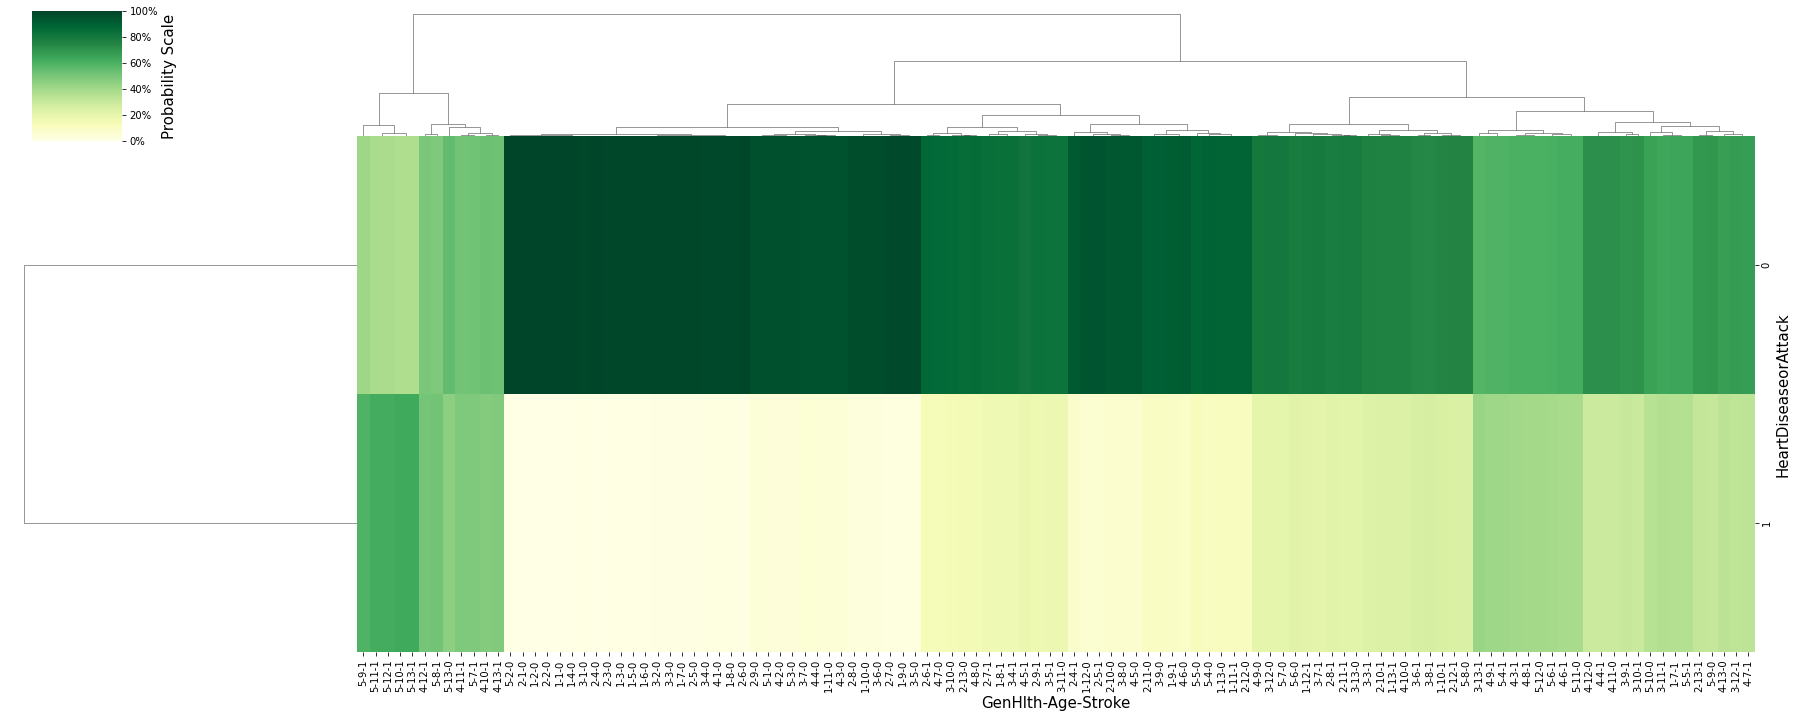

In [47]:
# Generate the cluster map
g = sns.clustermap(xs_vs_ys(df_xs, df_ys).drop(outliers,axis=0).T, cmap='YlGn', xticklabels=True, figsize=(25, 10))

# Get the colorbar associated with the plot
colorbar = g.ax_heatmap.collections[0].colorbar

# Create a formatter to convert values to percentage
formatter = mticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

# Set the font properties of the legend title
legend_title = 'Probability Scale'
colorbar.set_label(legend_title, fontsize=15)

# Set the formatter for the colorbar tick labels
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([formatter(tick) for tick in colorbar.get_ticks()])
g.ax_heatmap.set_xlabel('GenHlth-Age-Stroke', fontsize=15)
g.ax_heatmap.set_ylabel('HeartDiseaseorAttack', fontsize=15)

In [48]:
x_subgroups=[(5,9,1),(5,10,1),(5,11,1),(5,12,1),(5,13,1)]
y_subgroups=[1]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100,
                         outliers=outliers)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [1] with [(5, 9, 1), (5, 10, 1), (5, 11, 1), (5, 12, 1), (5, 13, 1)] is 62.0%
95 out of 100 samples show that the cluster has highest risk of [1] (at around 62.0%)


In [49]:
## 1
# GenHlth, Age, Stroke
    #GenHlth, Age
    #GenHlth, Stroke
    #Age, Stroke
print(xs_vs_ys([df["GenHlth"], df["Age"]], [df["HeartDiseaseorAttack"]]).loc[[(5,13),(5,12),(5,11),(5,10),(5,9)],(1)].mean())
print(xs_vs_ys([df["GenHlth"], df["Stroke"]], [df["HeartDiseaseorAttack"]]).loc[[(5,1)],(1)].mean())
print(xs_vs_ys([df["Age"], df["Stroke"]], [df["HeartDiseaseorAttack"]]).loc[[(13,1),(12,1),(11,1),(10,1),(9,1)],(1)].mean())

0.423565083063297
0.568685376661743
0.4027724577476165


# Balancing HeartDiseaseorAttack

In [50]:
from sklearn.utils import resample

In [51]:
df_HD_0 = df.loc[(df["HeartDiseaseorAttack"]==0),:]
df_HD_1 = df.loc[(df["HeartDiseaseorAttack"]==1),:]
size_HD_0 = df_HD_0.shape[0]
df_HD_1_over = resample(df_HD_1,replace=True,n_samples=size_HD_0,random_state=24) 

In [52]:
df_HD_1_over.shape

(229787, 22)

In [53]:
df_balance = pd.concat([df_HD_0,df_HD_1_over]).reset_index(drop=True)

In [54]:
df_balance.shape

(459574, 22)

# Random Forest HeartDiseaseorAttack

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [56]:
y = df_balance["HeartDiseaseorAttack"].to_numpy()
X = df_balance.drop(["HeartDiseaseorAttack"],axis=1).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [57]:
num_cpus = os.cpu_count()
print(f"Number of available CPUs: {num_cpus}")

Number of available CPUs: 8


In [65]:
n_estimators = [i for i in range(10,60,10)]
param_grid = {"n_estimators": n_estimators}
rfc = RandomForestClassifier(random_state=24)

In [66]:
from sklearn.model_selection import GridSearchCV

In [67]:
rf_Grid = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5, verbose = 1, n_jobs = 8)
rf_Grid.fit(X_train, y_train)
rfc = RandomForestClassifier(n_estimators=rf_Grid.best_params_["n_estimators"], random_state=24)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [68]:
rf_Grid.best_params_["n_estimators"]

30

In [69]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     45831
           1       0.93      0.99      0.96     46084

    accuracy                           0.96     91915
   macro avg       0.96      0.96      0.96     91915
weighted avg       0.96      0.96      0.96     91915



In [70]:
feature_names = df_balance.drop(["HeartDiseaseorAttack"],axis=1).columns
feature_names

Index(['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'Diabetes',
       'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age',
       'Education', 'Income', 'BMI_cat', 'PhysHlth_cat', 'MentHlth_cat'],
      dtype='object')

In [71]:
class_names = df_balance["HeartDiseaseorAttack"].unique()
class_names = ["No HD", "HD"]
class_names

['No HD', 'HD']

In [72]:
from sklearn.tree import plot_tree

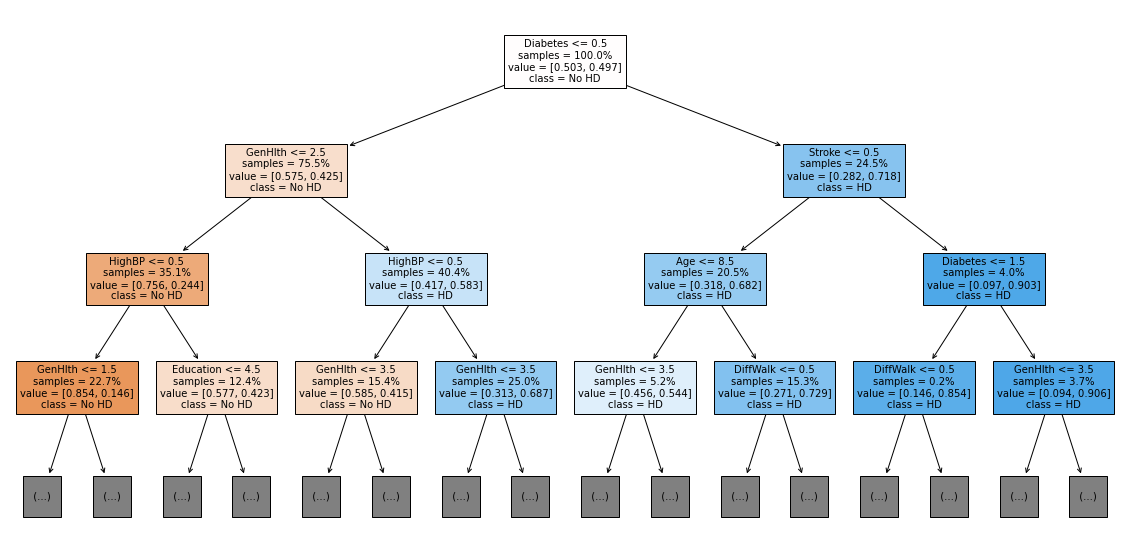

In [73]:
# We missed two-way Diabetes, Stroke -> 0.90 HD
plt.figure(figsize=(20,10))
plot_tree(rfc.estimators_[1], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

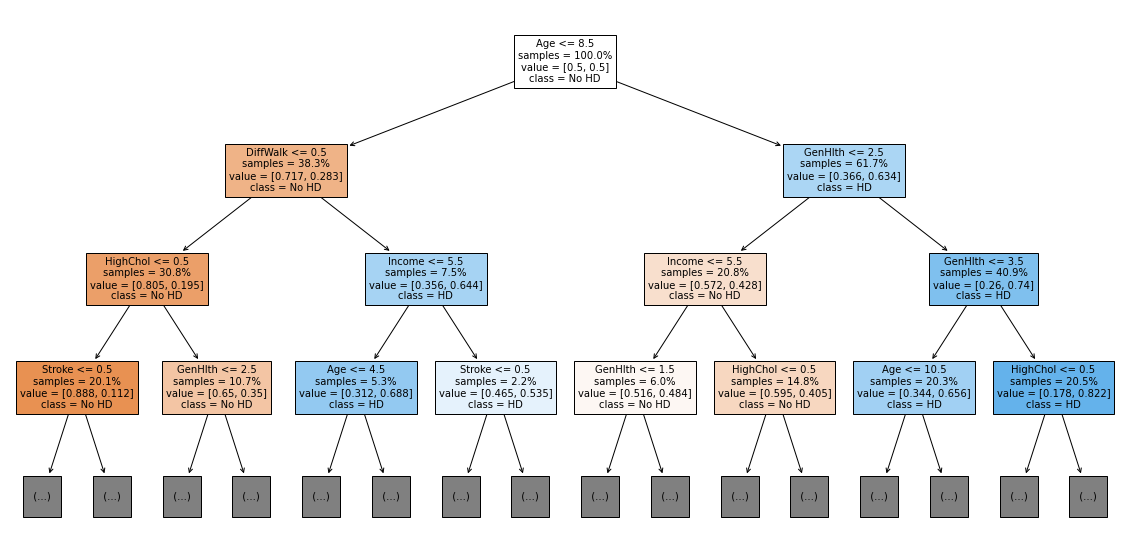

In [74]:
# GenHlth, Age -> 0.82 HD
plt.figure(figsize=(20,10))
plot_tree(rfc.estimators_[5], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False, 
          proportion=True)
plt.show()

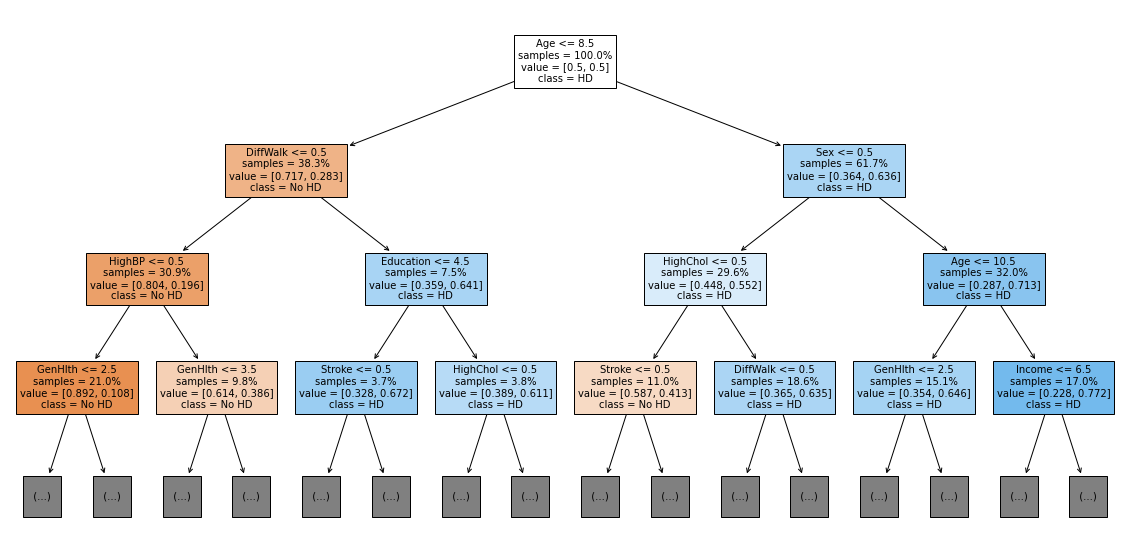

In [75]:
# We missed three-way Age, DiffWalk, HighBP -> 0.90 NO HD
plt.figure(figsize=(20,10))
plot_tree(rfc.estimators_[6], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

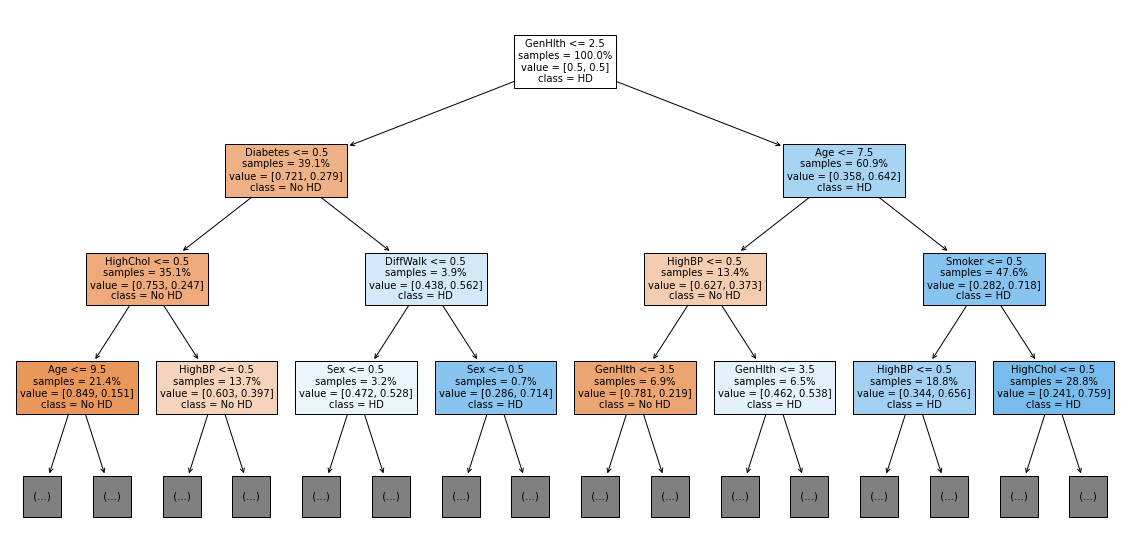

In [76]:
# GenHlth, Age and GenHlth, Age, Smoker -> Important to split
plt.figure(figsize=(20,10))
plot_tree(rfc.estimators_[9], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

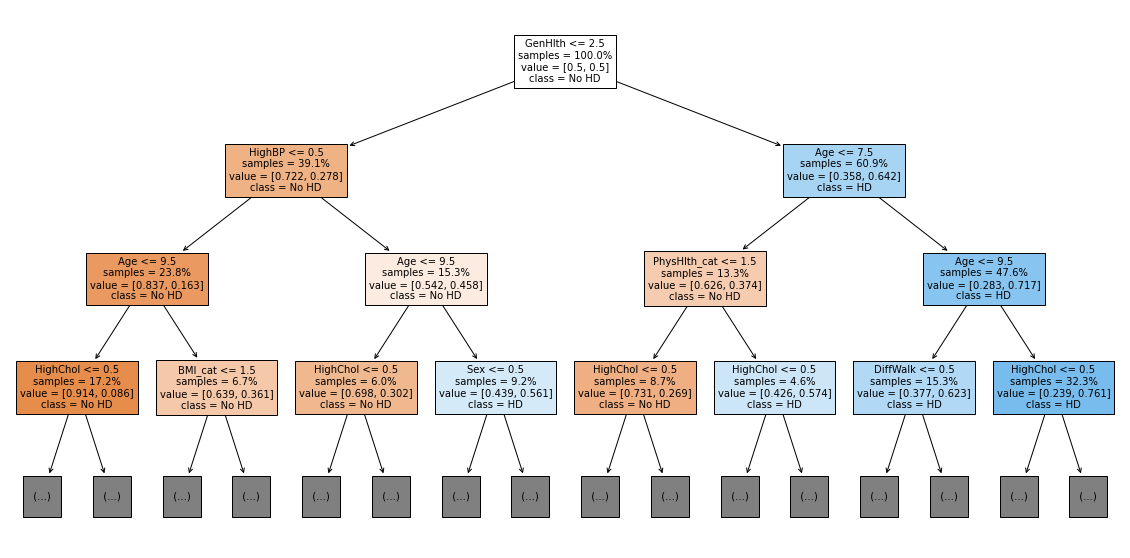

In [77]:
# GenHlth, HighBP, Age -> 0.91 NO HD
# GenHlth, HighBP, Age -> Important to split
# GenHlth, Age -> 0.76 HD
# GenHlth, Age -> Important to split
plt.figure(figsize=(20,10))
plot_tree(rfc.estimators_[10], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False, 
          proportion=True)
plt.show()

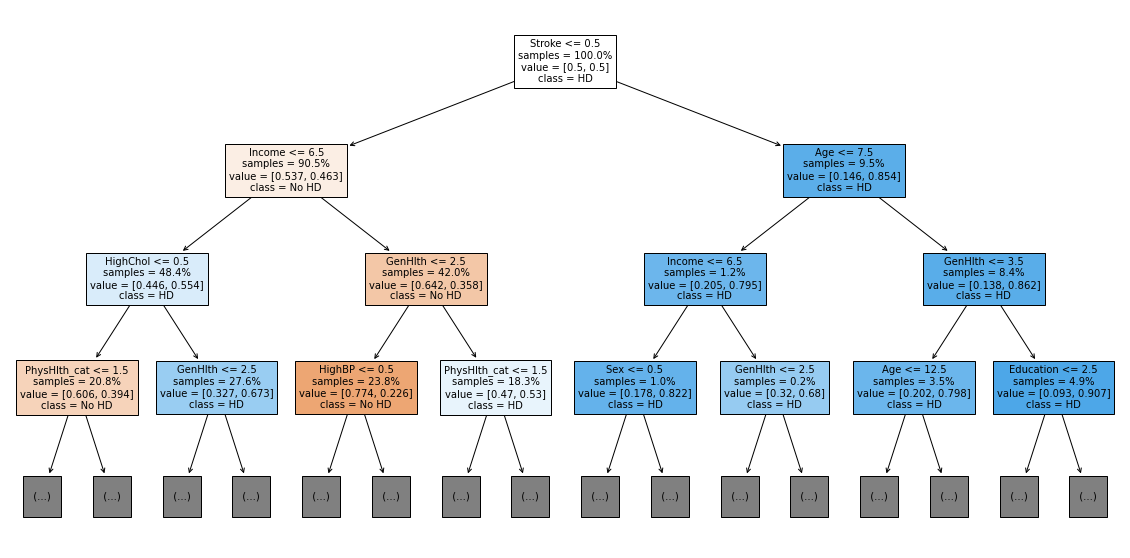

In [78]:
# GenHlth, Age, Stroke -> 0.91 HD
plt.figure(figsize=(20,10))
plot_tree(rfc.estimators_[11], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

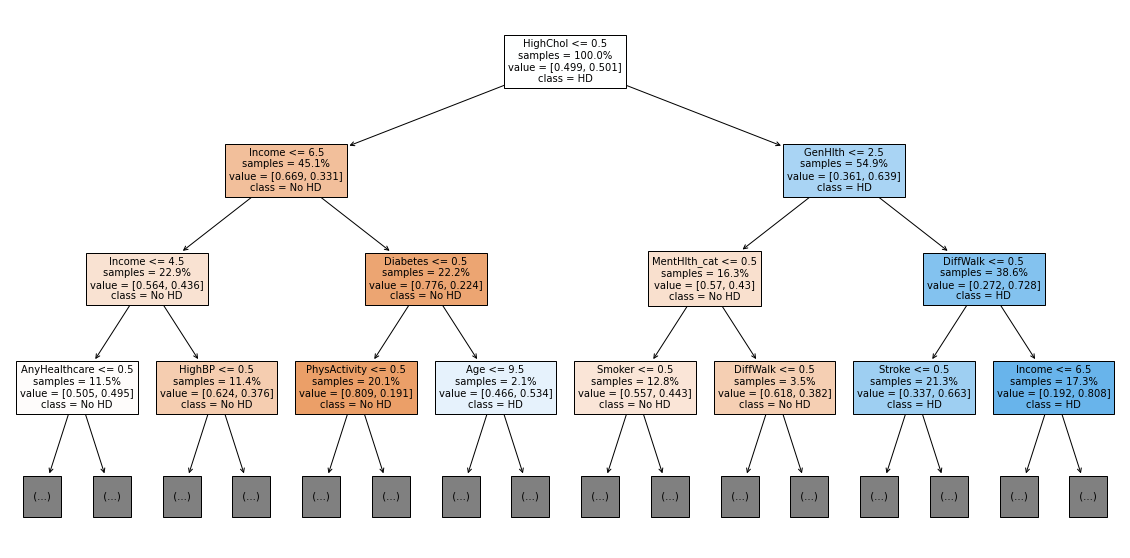

In [79]:
# Although HighChol shared high info, interaction with income -> 0.50
plt.figure(figsize=(20,10))
plot_tree(rfc.estimators_[8], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False, 
          proportion=True)
plt.show()

# Univariate HD_Stroke

In [80]:
sig_xs_HD_Stoke = sig_xs(df = df,
                         B = 100,
                         xs = df.columns.drop(["HeartDiseaseorAttack","Stroke"]),
                         df_ys = [df["HeartDiseaseorAttack"],df["Stroke"]],
                         predictor_type = "one",
                         sig_Info = 0)
sig_xs_HD_Stoke

,xs,Infos
0,GenHlth,0.040668
1,Age,0.034098
2,HighBP,0.026936
3,DiffWalk,0.025083
4,PhysHlth_cat,0.018397
5,HighChol,0.018318
6,Diabetes,0.015460
7,Income,0.014932
8,Smoker,0.007229
9,Education,0.006288


In [81]:
#This section display the probability table of HeartDiseaseorAttack+Stroke for the TOP 10 variable from above.
#We will show an example, then comment out the other 9 variable to avoid repetition

xs_vs_ys(df_xs=[df["GenHlth"]],df_ys=[df["HeartDiseaseorAttack"],df["Stroke"]])

#xs_vs_ys(df_xs=[df["Age"]],df_ys=[df["HeartDiseaseorAttack"],df["Stroke"]])
#xs_vs_ys(df_xs=[df["HighBP"]],df_ys=[df["HeartDiseaseorAttack"],df["Stroke"]])
#xs_vs_ys(df_xs=[df["DiffWalk"]],df_ys=[df["HeartDiseaseorAttack"],df["Stroke"]])
#xs_vs_ys(df_xs=[df["PhysHlth_cat"]],df_ys=[df["HeartDiseaseorAttack"],df["Stroke"]])
#xs_vs_ys(df_xs=[df["HighChol"]],df_ys=[df["HeartDiseaseorAttack"],df["Stroke"]])
#xs_vs_ys(df_xs=[df["Diabetes"]],df_ys=[df["HeartDiseaseorAttack"],df["Stroke"]])
#xs_vs_ys(df_xs=[df["Income"]],df_ys=[df["HeartDiseaseorAttack"],df["Stroke"]])
#xs_vs_ys(df_xs=[df["Smoker"]],df_ys=[df["HeartDiseaseorAttack"],df["Stroke"]])
#xs_vs_ys(df_xs=[df["Education"]],df_ys=[df["HeartDiseaseorAttack"],df["Stroke"]])

HeartDiseaseorAttack         0                   1          
Stroke                       0         1         0         1
GenHlth                                                     
1                     0.969757  0.007815  0.020420  0.002009
2                     0.939181  0.014481  0.042140  0.004198
3                     0.866920  0.028462  0.091135  0.013484
4                     0.733608  0.053278  0.172030  0.041083
5                     0.587534  0.072511  0.244351  0.095605

# Two-Way Interactions HD_Stroke

In [82]:
sig_x1_x2_HD_Stoke = sig_xs(df = df,
                            B = 100,
                            xs = df.columns.drop(["HeartDiseaseorAttack","Stroke"]),
                            df_ys = [df["HeartDiseaseorAttack"],df["Stroke"]],
                            predictor_type = "two",
                            sig_Info = 0.040668)
sig_x1_x2_HD_Stoke

,x1_x2,Infos
0,"(GenHlth, Age)",0.069978
1,"(HighBP, GenHlth)",0.054159
2,"(DiffWalk, Age)",0.052749
3,"(Age, PhysHlth_cat)",0.051834
4,"(HighChol, GenHlth)",0.051208
5,"(HighBP, Age)",0.047856
6,"(Age, Income)",0.047276
7,"(GenHlth, DiffWalk)",0.046348
8,"(Diabetes, GenHlth)",0.045946
9,"(GenHlth, Sex)",0.044879


# GenHlth, Age vs HD_Stroke

In [83]:
df_xs=[df["GenHlth"],df["Age"]]
df_ys=[df["HeartDiseaseorAttack"],df["Stroke"]]

Text(1316.9999999999998, 0.5, 'HeartDiseaseorAttack-Stroke')

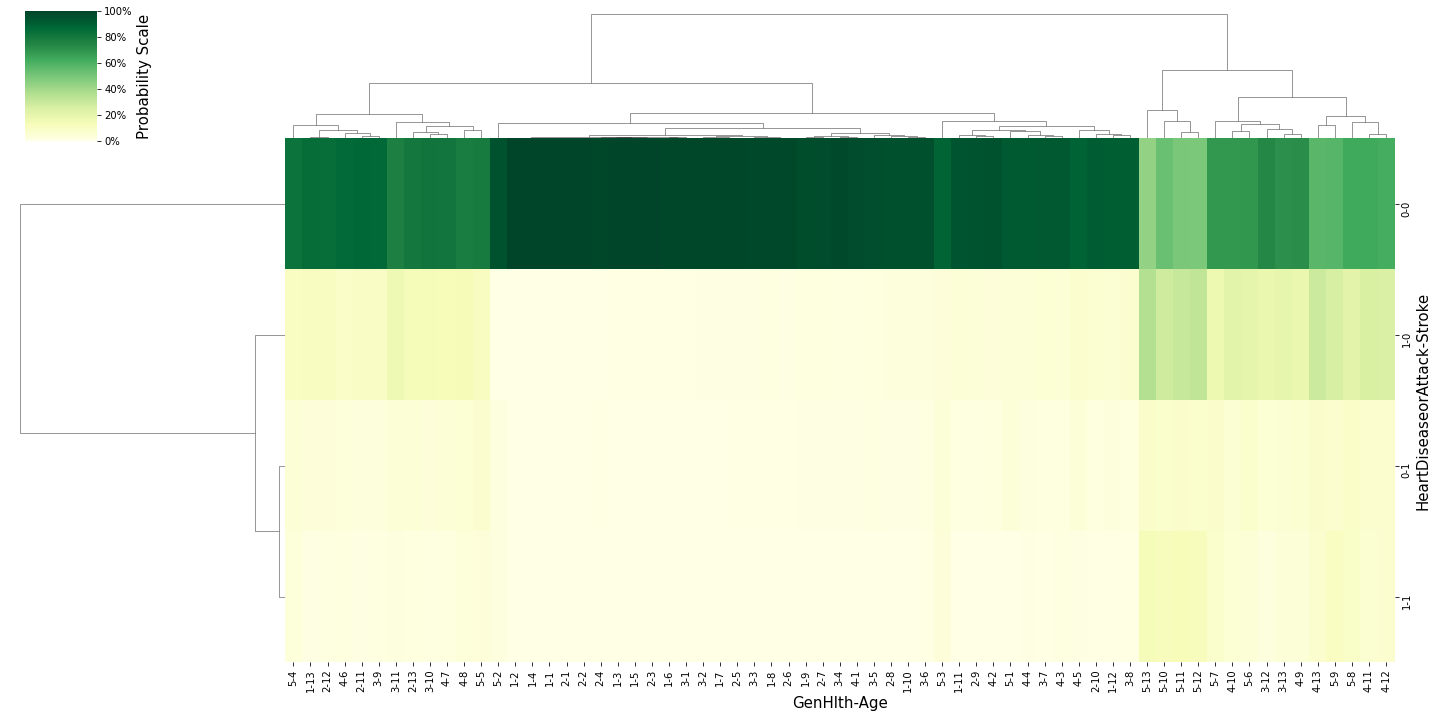

In [84]:
# Generate the cluster map
g = sns.clustermap(xs_vs_ys(df_xs, df_ys).T, cmap='YlGn', xticklabels=True, figsize=(20, 10))

# Get the colorbar associated with the plot
colorbar = g.ax_heatmap.collections[0].colorbar

# Create a formatter to convert values to percentage
formatter = mticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

# Set the font properties of the legend title
legend_title = 'Probability Scale'
colorbar.set_label(legend_title, fontsize=15)

# Set the formatter for the colorbar tick labels
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([formatter(tick) for tick in colorbar.get_ticks()])
g.ax_heatmap.set_xlabel('GenHlth-Age', fontsize=15)
g.ax_heatmap.set_ylabel('HeartDiseaseorAttack-Stroke', fontsize=15)

In [85]:
x_subgroups=[(5,10),(5,11),(5,12),(5,13)]
y_subgroups=[(1,1)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [(1, 1)] with [(5, 10), (5, 11), (5, 12), (5, 13)] is 12.0%
100 out of 100 samples show that the cluster has highest risk of [(1, 1)] (at around 12.0%)


In [86]:
x_subgroups=[(5,10),(5,11),(5,12),(5,13)]
y_subgroups=[(1,0)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [(1, 0)] with [(5, 10), (5, 11), (5, 12), (5, 13)] is 32.0%
100 out of 100 samples show that the cluster has highest risk of [(1, 0)] (at around 32.0%)


In [87]:
x_subgroups=[(5,13)]
y_subgroups=[(0,0)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="low")
# Risk of at least one = 1 - 0.43 = 0.57

Mean probability of [(0, 0)] with [(5, 13)] is 43.0%
99 out of 100 samples show that the cluster has lowest risk of [(0, 0)] (at around 43.0%)


In [88]:
## 00
# GenHlth
# Age
print(1-xs_vs_ys([df["GenHlth"]], [df["HeartDiseaseorAttack"], df["Stroke"]]).loc[[(5)],(0,0)].mean())
print(1-xs_vs_ys([df["Age"]], [df["HeartDiseaseorAttack"], df["Stroke"]]).loc[[(13)],(0,0)].mean())

0.41246585547554016
0.2956286356044462


# Diabetes, GenHlth vs HD_Stroke

In [89]:
df_xs = [df["Diabetes"],df["GenHlth"]]
df_ys = [df["HeartDiseaseorAttack"],df["Stroke"]]

Text(1316.9999999999998, 0.5, 'HeartDiseaseorAttack-Stroke')

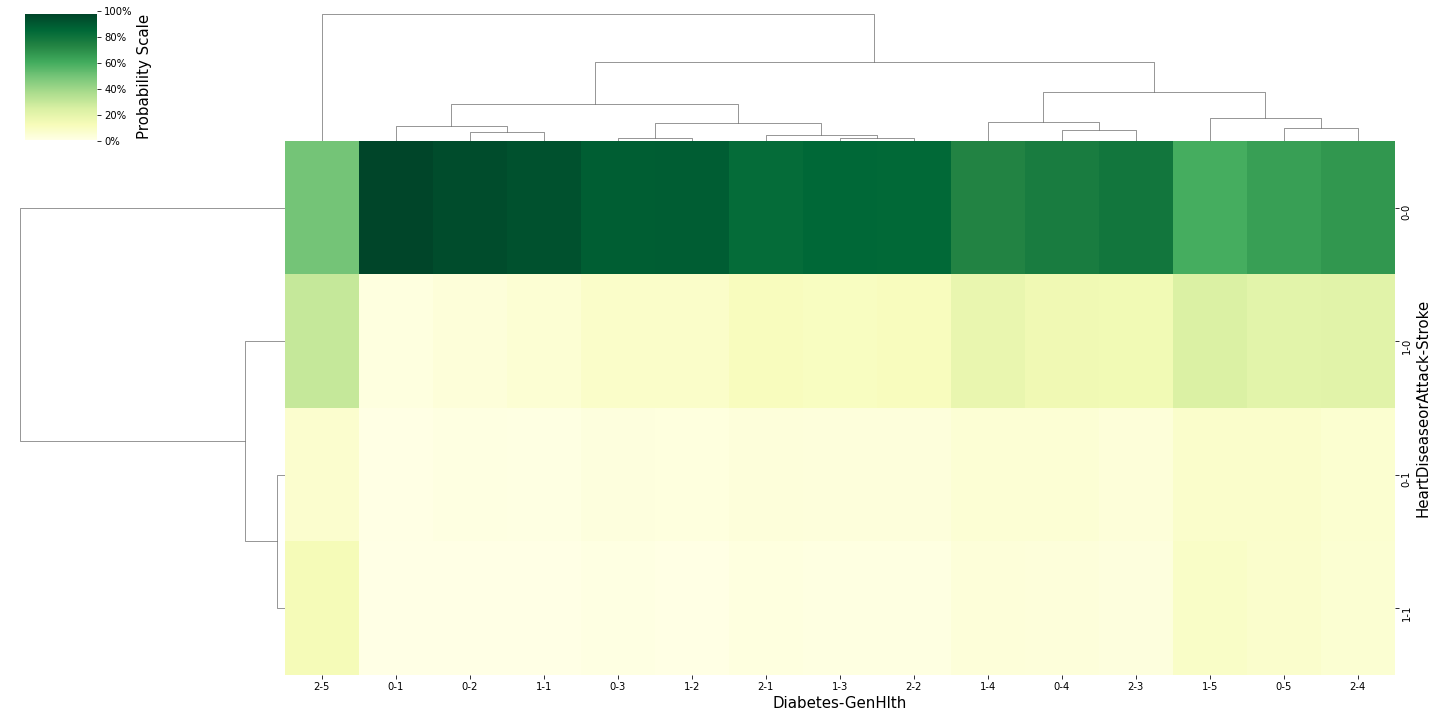

In [90]:
# Generate the cluster map
g = sns.clustermap(xs_vs_ys(df_xs, df_ys).T, cmap='YlGn', xticklabels=True, figsize=(20, 10))

# Get the colorbar associated with the plot
colorbar = g.ax_heatmap.collections[0].colorbar

# Create a formatter to convert values to percentage
formatter = mticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

# Set the font properties of the legend title
legend_title = 'Probability Scale'
colorbar.set_label(legend_title, fontsize=15)

# Set the formatter for the colorbar tick labels
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([formatter(tick) for tick in colorbar.get_ticks()])
g.ax_heatmap.set_xlabel('Diabetes-GenHlth', fontsize=15)
g.ax_heatmap.set_ylabel('HeartDiseaseorAttack-Stroke', fontsize=15)

In [91]:
x_subgroups=[(2, 5)]
y_subgroups=[(1, 1)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [(1, 1)] with [(2, 5)] is 13.0%
100 out of 100 samples show that the cluster has highest risk of [(1, 1)] (at around 13.0%)


In [92]:
x_subgroups=[(2, 5)]
y_subgroups=[(1, 0)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [(1, 0)] with [(2, 5)] is 30.0%
100 out of 100 samples show that the cluster has highest risk of [(1, 0)] (at around 30.0%)


In [93]:
x_subgroups=[(2, 5)]
y_subgroups=[(0, 0)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="low")
# Risk of at least one = 1 - 0.50 = 0.50

Mean probability of [(0, 0)] with [(2, 5)] is 50.0%
100 out of 100 samples show that the cluster has lowest risk of [(0, 0)] (at around 50.0%)


In [94]:
## 00
# Diabetes
# GenHlth
print(1-xs_vs_ys([df["GenHlth"]], [df["HeartDiseaseorAttack"], df["Stroke"]]).loc[[(5)],(0,0)].mean())
print(1-xs_vs_ys([df["Diabetes"]], [df["HeartDiseaseorAttack"], df["Stroke"]]).loc[[(2)],(0,0)].mean())

0.41246585547554016
0.26905448989984726


# Three-Way Interactions HD_Stroke

In [95]:
GenHlth_Age_sig_x1_x2_x3_HD_Stroke = sig_xs(df = df,
                                            B = 100,
                                            xs = ("GenHlth","Age"),
                                            df_ys = [df["HeartDiseaseorAttack"],df["Stroke"]],
                                            predictor_type = "three",
                                            sig_Info = 0)
GenHlth_Age_sig_x1_x2_x3_HD_Stroke

,x1_x2_x3,Infos
0,"(GenHlth, Age, Income)",0.076960
1,"(GenHlth, Age, HighBP)",0.076518
2,"(GenHlth, Age, Sex)",0.076484
3,"(GenHlth, Age, HighChol)",0.076165
4,"(GenHlth, Age, Diabetes)",0.073832
5,"(GenHlth, Age, Education)",0.073516
6,"(GenHlth, Age, DiffWalk)",0.073441
7,"(GenHlth, Age, PhysHlth_cat)",0.073402
8,"(GenHlth, Age, BMI_cat)",0.073245
9,"(GenHlth, Age, MentHlth_cat)",0.073076


# GenHlth, Age, HighBP vs HD_Stroke

In [96]:
df_xs = [df["GenHlth"],df["Age"],df["HighBP"]]
df_ys = [df["HeartDiseaseorAttack"],df["Stroke"]]

In [97]:
small_group_size = 20
xs_vs_ys_ct_df = xs_vs_ys(df_xs,df_ys,ct=True)
outliers = xs_vs_ys_ct_df.index[xs_vs_ys_ct_df["All"] < small_group_size]

Text(1640.9999999999998, 0.5, 'HeartDiseaseorAttack-Stroke')

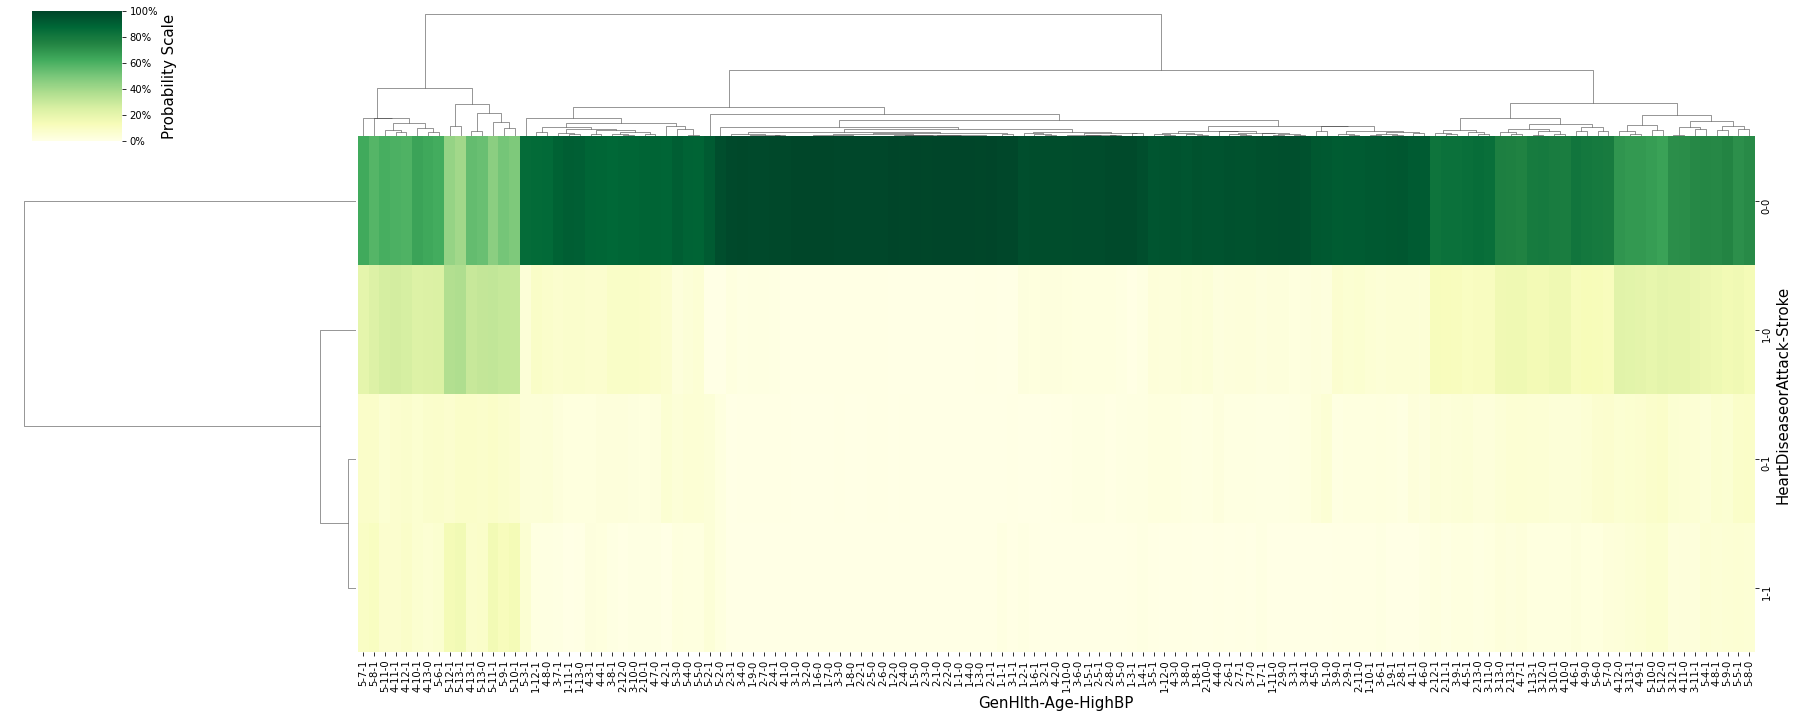

In [98]:
# Generate the cluster map
g = sns.clustermap(xs_vs_ys(df_xs, df_ys).drop(outliers,axis=0).T, cmap='YlGn', xticklabels=True, figsize=(25, 10))

# Get the colorbar associated with the plot
colorbar = g.ax_heatmap.collections[0].colorbar

# Create a formatter to convert values to percentage
formatter = mticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

# Set the font properties of the legend title
legend_title = 'Probability Scale'
colorbar.set_label(legend_title, fontsize=15)

# Set the formatter for the colorbar tick labels
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([formatter(tick) for tick in colorbar.get_ticks()])
g.ax_heatmap.set_xlabel('GenHlth-Age-HighBP', fontsize=15)
g.ax_heatmap.set_ylabel('HeartDiseaseorAttack-Stroke', fontsize=15)

In [99]:
x_subgroups=[(5,10,1),(5,11,1),(5,12,1),(5,13,1)]
y_subgroups=[(1,1)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [(1, 1)] with [(5, 10, 1), (5, 11, 1), (5, 12, 1), (5, 13, 1)] is 14.000000000000002%
98 out of 100 samples show that the cluster has highest risk of [(1, 1)] (at around 14.000000000000002%)


In [100]:
x_subgroups=[(5,13,1),(5,12,1)]
y_subgroups=[(1,0)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [(1, 0)] with [(5, 13, 1), (5, 12, 1)] is 36.0%
94 out of 100 samples show that the cluster has highest risk of [(1, 0)] (at around 36.0%)


In [101]:
x_subgroups=[(5,11,1),(5,12,1),(5,13,1)]
y_subgroups=[(0,0)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="low")
# Risk of at least one = 1 - 0.50 = 0.50

Mean probability of [(0, 0)] with [(5, 11, 1), (5, 12, 1), (5, 13, 1)] is 43.0%
100 out of 100 samples show that the cluster has lowest risk of [(0, 0)] (at around 43.0%)


In [102]:
## 00
# GenHlth, Age, HighBP
    #GenHlth, Age
    #GenHlth, HighBP
    #Age, HighBP
print(1-xs_vs_ys([df["GenHlth"], df["Age"]], [df["HeartDiseaseorAttack"], df["Stroke"]]).loc[[(5,13),(5,12),(5,11)],(0,0)].mean())
print(1-xs_vs_ys([df["GenHlth"], df["HighBP"]], [df["HeartDiseaseorAttack"], df["Stroke"]]).loc[[(5,1)],(0,0)].mean())
print(1-xs_vs_ys([df["Age"], df["HighBP"]], [df["HeartDiseaseorAttack"], df["Stroke"]]).loc[[(13,1),(12,1), (11,1)],(0,0)].mean())

0.5299089976112961
0.4770718891807977
0.2956354701149797


# GenHlth, Age, Sex vs HD_Stroke

In [103]:
df_xs = [df["GenHlth"],df["Age"],df["Sex"]]
df_ys = [df["HeartDiseaseorAttack"],df["Stroke"]]

Text(1640.9999999999998, 0.5, 'HeartDiseaseorAttack-Stroke')

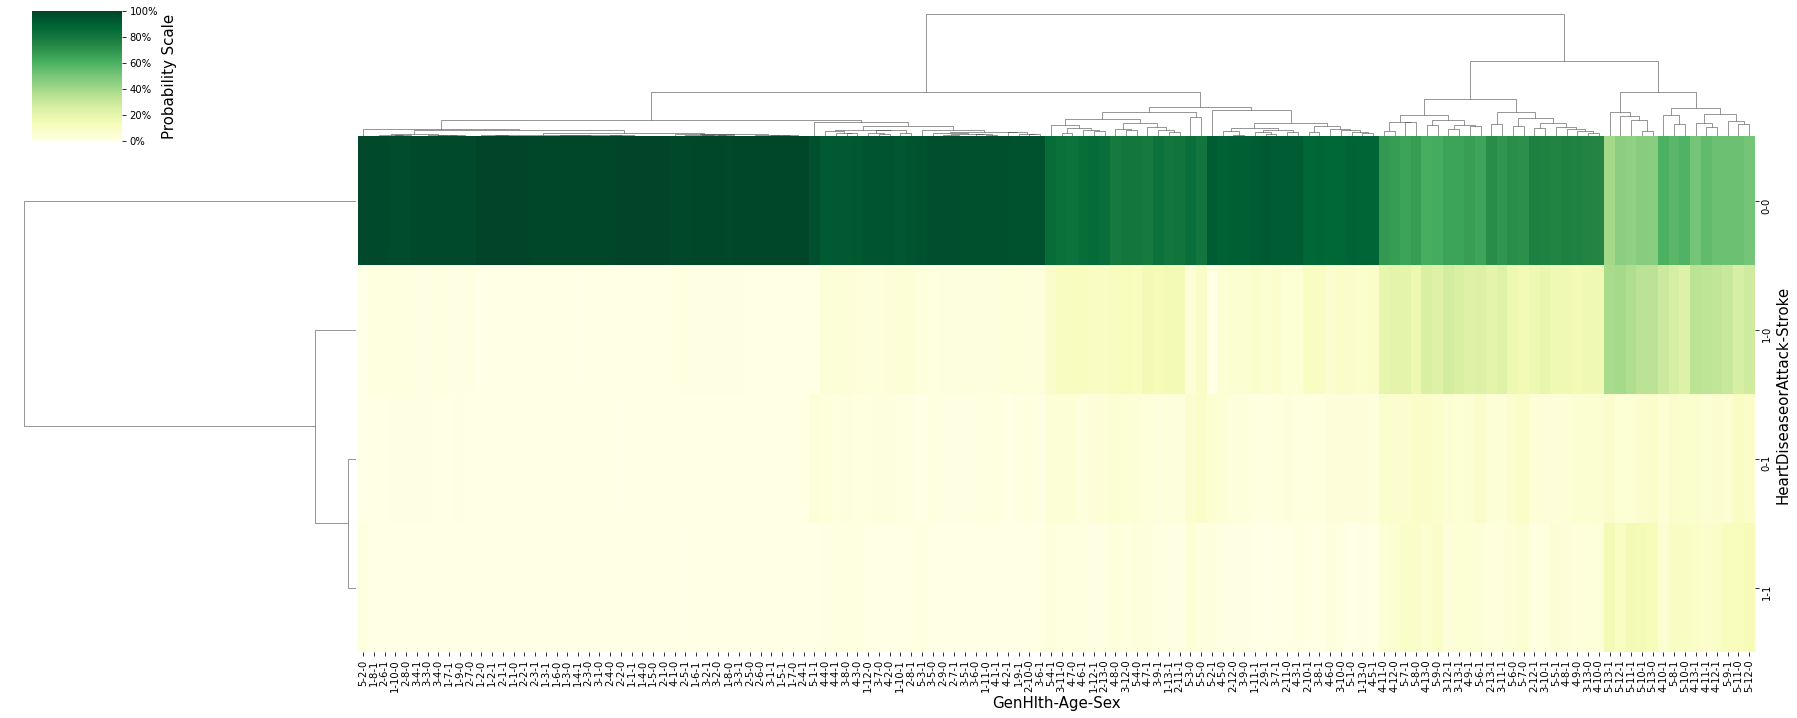

In [104]:
# Generate the cluster map
g = sns.clustermap(xs_vs_ys(df_xs, df_ys).T, cmap='YlGn', xticklabels=True, figsize=(25, 10))

# Get the colorbar associated with the plot
colorbar = g.ax_heatmap.collections[0].colorbar

# Create a formatter to convert values to percentage
formatter = mticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

# Set the font properties of the legend title
legend_title = 'Probability Scale'
colorbar.set_label(legend_title, fontsize=15)

# Set the formatter for the colorbar tick labels
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([formatter(tick) for tick in colorbar.get_ticks()])
g.ax_heatmap.set_xlabel('GenHlth-Age-Sex', fontsize=15)
g.ax_heatmap.set_ylabel('HeartDiseaseorAttack-Stroke', fontsize=15)

In [105]:
x_subgroups=[(5,9,0),(5,9,1),(5,10,0),(5,10,1),(5,11,0),(5,11,1),(5,12,0),(5,12,1),(5,13,0),(5,13,1)]
y_subgroups=[(1,1)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [(1, 1)] with [(5, 9, 0), (5, 9, 1), (5, 10, 0), (5, 10, 1), (5, 11, 0), (5, 11, 1), (5, 12, 0), (5, 12, 1), (5, 13, 0), (5, 13, 1)] is 12.0%
98 out of 100 samples show that the cluster has highest risk of [(1, 1)] (at around 12.0%)


In [106]:
x_subgroups=[(5,10,1),(5,11,1),(5,12,1),(5,13,1),(5,13,0)]
y_subgroups=[(1,0)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [(1, 0)] with [(5, 10, 1), (5, 11, 1), (5, 12, 1), (5, 13, 1), (5, 13, 0)] is 36.0%
93 out of 100 samples show that the cluster has highest risk of [(1, 0)] (at around 36.0%)


In [107]:
x_subgroups=[(5,10,1),(5,11,1),(5,12,1),(5,13,1),(5,13,0)]
y_subgroups=[(0,0)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100)
reliablity(x_subgroups,y_subgroups,cb_df,risk="low")
# Risk of at least one = 1 - 0.44 = 0.56

Mean probability of [(0, 0)] with [(5, 10, 1), (5, 11, 1), (5, 12, 1), (5, 13, 1), (5, 13, 0)] is 44.0%
99 out of 100 samples show that the cluster has lowest risk of [(0, 0)] (at around 44.0%)


In [108]:
## 00
# GenHlth, Age, Sex
    #GenHlth, Age
    #GenHlth, Sex
    #Age, Sex
print(1-xs_vs_ys([df["GenHlth"], df["Age"]], [df["HeartDiseaseorAttack"], df["Stroke"]]).loc[[(5,13),(5,12),(5,11),(5,10)],(0,0)].mean())
print(1-xs_vs_ys([df["GenHlth"], df["Sex"]], [df["HeartDiseaseorAttack"], df["Stroke"]]).loc[[(5,1), (5,0)],(0,0)].mean())
print(1-xs_vs_ys([df["Age"], df["Sex"]], [df["HeartDiseaseorAttack"], df["Stroke"]]).loc[[(13,1),(13,0),(12,1), (11,1), (10,1)],(0,0)].mean())

0.5147382686228535
0.41908814137587724
0.28232172202457717


# GenHlth, Age, HighChol vs HD_Stroke

In [109]:
df_xs=[df["GenHlth"],df["Age"], df["HighChol"]]
df_ys=[df["HeartDiseaseorAttack"],df["Stroke"]]

Text(1640.9999999999998, 0.5, 'HeartDiseaseorAttack-Stroke')

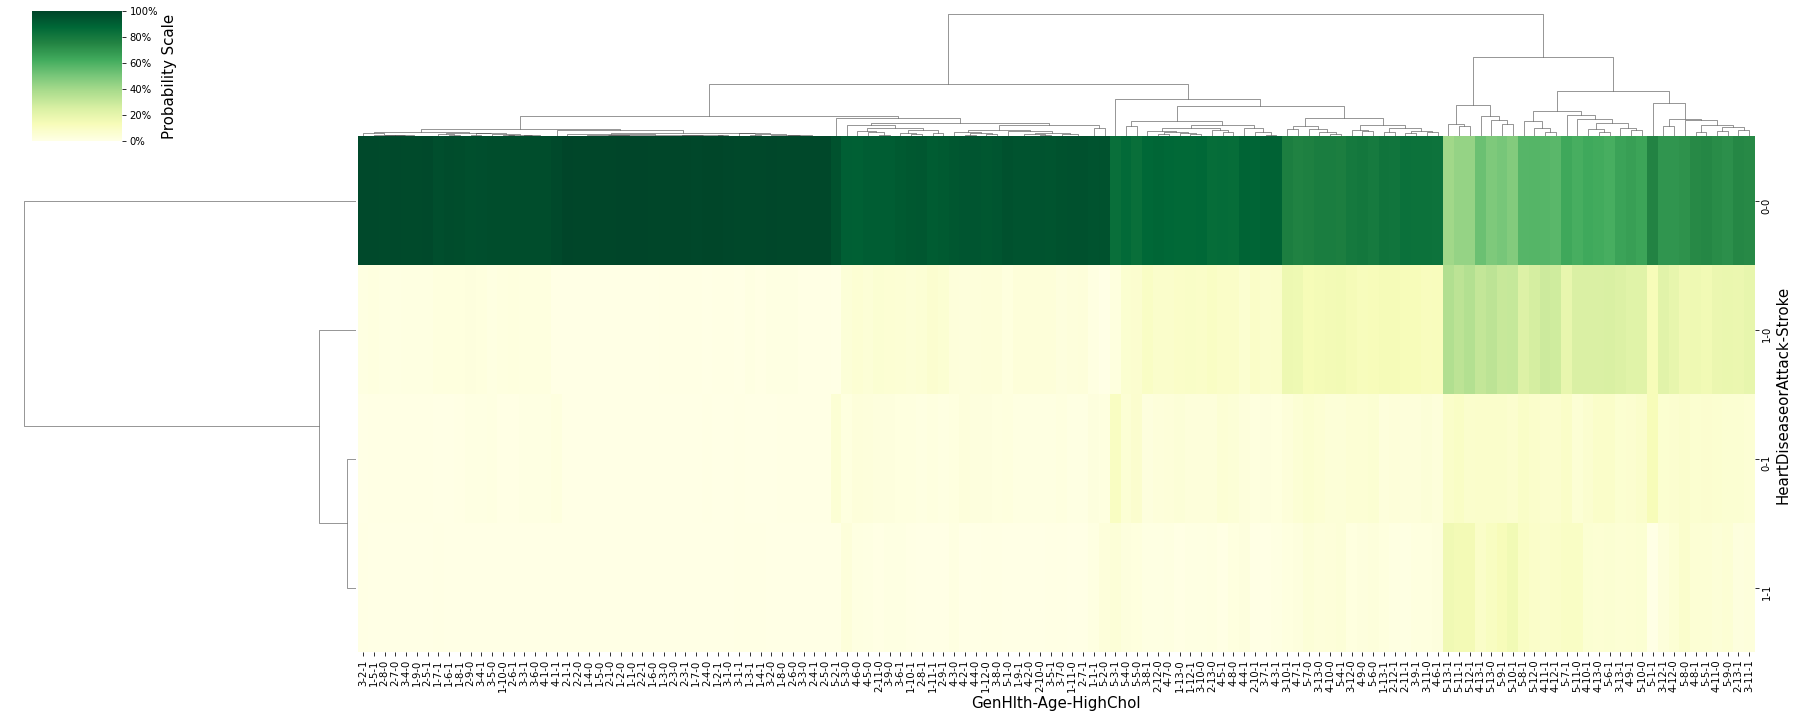

In [110]:
# Generate the cluster map
g = sns.clustermap(xs_vs_ys(df_xs, df_ys).T, cmap='YlGn', xticklabels=True, figsize=(25, 10))

# Get the colorbar associated with the plot
colorbar = g.ax_heatmap.collections[0].colorbar

# Create a formatter to convert values to percentage
formatter = mticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

# Set the font properties of the legend title
legend_title = 'Probability Scale'
colorbar.set_label(legend_title, fontsize=15)

# Set the formatter for the colorbar tick labels
colorbar.set_ticks(colorbar.get_ticks())
colorbar.set_ticklabels([formatter(tick) for tick in colorbar.get_ticks()])
g.ax_heatmap.set_xlabel('GenHlth-Age-HighChol', fontsize=15)
g.ax_heatmap.set_ylabel('HeartDiseaseorAttack-Stroke', fontsize=15)

In [111]:
x_subgroups=[(5,9,1),(5,10,1),(5,11,1),(5,12,1),(5,13,1),(5,13,0)] 
y_subgroups=[(1,1)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100,
                        outliers = outliers)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [(1, 1)] with [(5, 9, 1), (5, 10, 1), (5, 11, 1), (5, 12, 1), (5, 13, 1), (5, 13, 0)] is 14.000000000000002%
99 out of 100 samples show that the cluster has highest risk of [(1, 1)] (at around 14.000000000000002%)


In [112]:
x_subgroups=[(5,13,1), (5,12,1), (5,13,0), (5,11,1), (5,10,1)] 
y_subgroups=[(1,0)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100,
                        outliers = outliers)
reliablity(x_subgroups,y_subgroups,cb_df,risk="high")

Mean probability of [(1, 0)] with [(5, 13, 1), (5, 12, 1), (5, 13, 0), (5, 11, 1), (5, 10, 1)] is 34.0%
97 out of 100 samples show that the cluster has highest risk of [(1, 0)] (at around 34.0%)


In [113]:
x_subgroups=[(5,13,1), (5,12,1), (5,13,0), (5,11,1), (5,10,1)] 
y_subgroups=[(0,0)]
cb_df = common_branch_df(df,
                         df_xs,
                         df_ys,
                         x_subgroups,
                         y_subgroups,
                         B=100,
                        outliers = outliers)
reliablity(x_subgroups,y_subgroups,cb_df,risk="low")
# Risk of at least one = 1 - 0.45 = 0.55

Mean probability of [(0, 0)] with [(5, 13, 1), (5, 12, 1), (5, 13, 0), (5, 11, 1), (5, 10, 1)] is 45.0%
100 out of 100 samples show that the cluster has lowest risk of [(0, 0)] (at around 45.0%)


In [114]:
## 00
# GenHlth, Age, HighChol
    #GenHlth, Age
    #GenHlth, HighChol
    #Age, HighChol
print(1-xs_vs_ys([df["GenHlth"], df["Age"]], [df["HeartDiseaseorAttack"], df["Stroke"]]).loc[[(5,11),(5,12),(5,13),(5,10)],(0,0)].mean())
print(1-xs_vs_ys([df["GenHlth"], df["HighChol"]], [df["HeartDiseaseorAttack"], df["Stroke"]]).loc[[(5,1),(5,0)],(0,0)].mean())
print(1-xs_vs_ys([df["Age"], df["HighChol"]], [df["HeartDiseaseorAttack"], df["Stroke"]]).loc[[(11,1),(12,1),(13,1),(10,1),(13,0)],(0,0)].mean())

0.5147382686228535
0.3911953550263034
0.2701258210408858


# Balancing HD_Stroke

In [115]:
df_HD_Stroke_00 = df.loc[(df["HeartDiseaseorAttack"]==0)&(df["Stroke"]==0),:]
df_HD_Stroke_01 = df.loc[(df["HeartDiseaseorAttack"]==0)&(df["Stroke"]==1),:]
df_HD_Stroke_10 = df.loc[(df["HeartDiseaseorAttack"]==1)&(df["Stroke"]==0),:]
df_HD_Stroke_11 = df.loc[(df["HeartDiseaseorAttack"]==1)&(df["Stroke"]==1),:]
balance_size = int(df.shape[0]/4)
df_HD_Stroke_00_balance = resample(df_HD_Stroke_00,replace=True,n_samples=balance_size,random_state=24) 
df_HD_Stroke_01_balance = resample(df_HD_Stroke_01,replace=True,n_samples=balance_size,random_state=24) 
df_HD_Stroke_10_balance = resample(df_HD_Stroke_10,replace=True,n_samples=balance_size,random_state=24) 
df_HD_Stroke_11_balance = resample(df_HD_Stroke_11,replace=True,n_samples=balance_size,random_state=24) 
df_balance = pd.concat([df_HD_Stroke_00_balance,
                        df_HD_Stroke_01_balance,
                        df_HD_Stroke_10_balance,
                        df_HD_Stroke_11_balance]).reset_index(drop=True)
df_balance["HD_Stroke"] = np.repeat([0,1,2,3], balance_size)

In [116]:
xs_vs_ys([df_balance["HeartDiseaseorAttack"],df_balance["Stroke"]],[df_balance["HD_Stroke"]],ct=True)

HD_Stroke                        0      1      2      3     All
HeartDiseaseorAttack Stroke                                    
0                    0       63420      0      0      0   63420
                     1           0  63420      0      0   63420
1                    0           0      0  63420      0   63420
                     1           0      0      0  63420   63420
All                          63420  63420  63420  63420  253680

# Random Forest HD_Stroke

In [117]:
y = df_balance["HD_Stroke"].to_numpy()
X = df_balance.drop(["HeartDiseaseorAttack","Stroke","HD_Stroke"],axis=1).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [119]:
n_estimators = [i for i in range(50,110,10)]
param_grid = {"n_estimators": n_estimators}
rfc = RandomForestClassifier(random_state=24)
rf_Grid = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5, verbose = 3, n_jobs = 8)
rf_Grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=24), n_jobs=8,
             param_grid={'n_estimators': [50, 60, 70, 80, 90, 100]}, verbose=3)

In [120]:
rf_Grid.best_params_["n_estimators"]

100

In [121]:
rfc = RandomForestClassifier(n_estimators=rf_Grid.best_params_["n_estimators"], random_state=24)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [122]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.83      0.89     12797
           1       0.96      0.99      0.97     12667
           2       0.87      0.94      0.90     12672
           3       0.98      1.00      0.99     12600

    accuracy                           0.94     50736
   macro avg       0.94      0.94      0.94     50736
weighted avg       0.94      0.94      0.94     50736



In [123]:
feature_names = df_balance.drop(["HeartDiseaseorAttack","Stroke","HD_Stroke"],axis=1).columns
feature_names

Index(['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Diabetes', 'PhysActivity',
       'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
       'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income', 'BMI_cat', 'PhysHlth_cat', 'MentHlth_cat'],
      dtype='object')

In [124]:
#class_names = df_balance["HD_Stroke"].unique()
#class_names = [str(i) for i in class_names]
class_names = ["None", "Stroke", "HD", "Both"]
class_names

['None', 'Stroke', 'HD', 'Both']

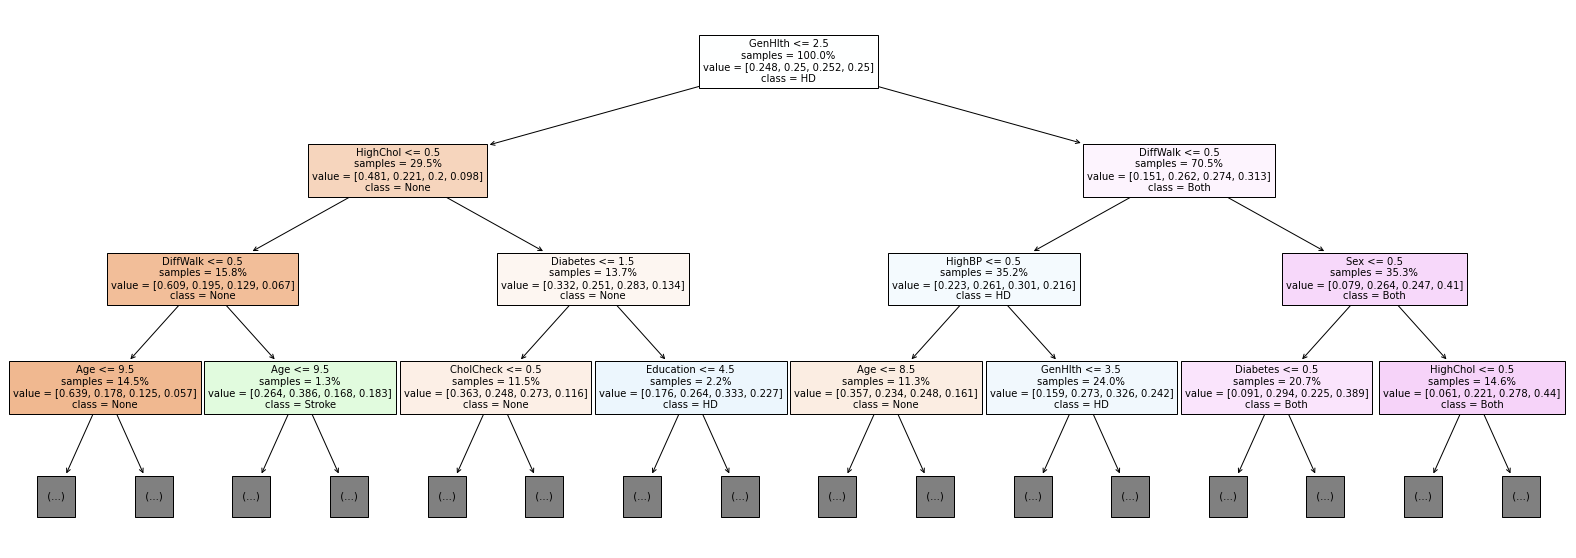

In [125]:
# GenHlth -> Increase but small (likely because of cutoff)
# GenHlth -> DiffWalk -> Sex
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[4], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

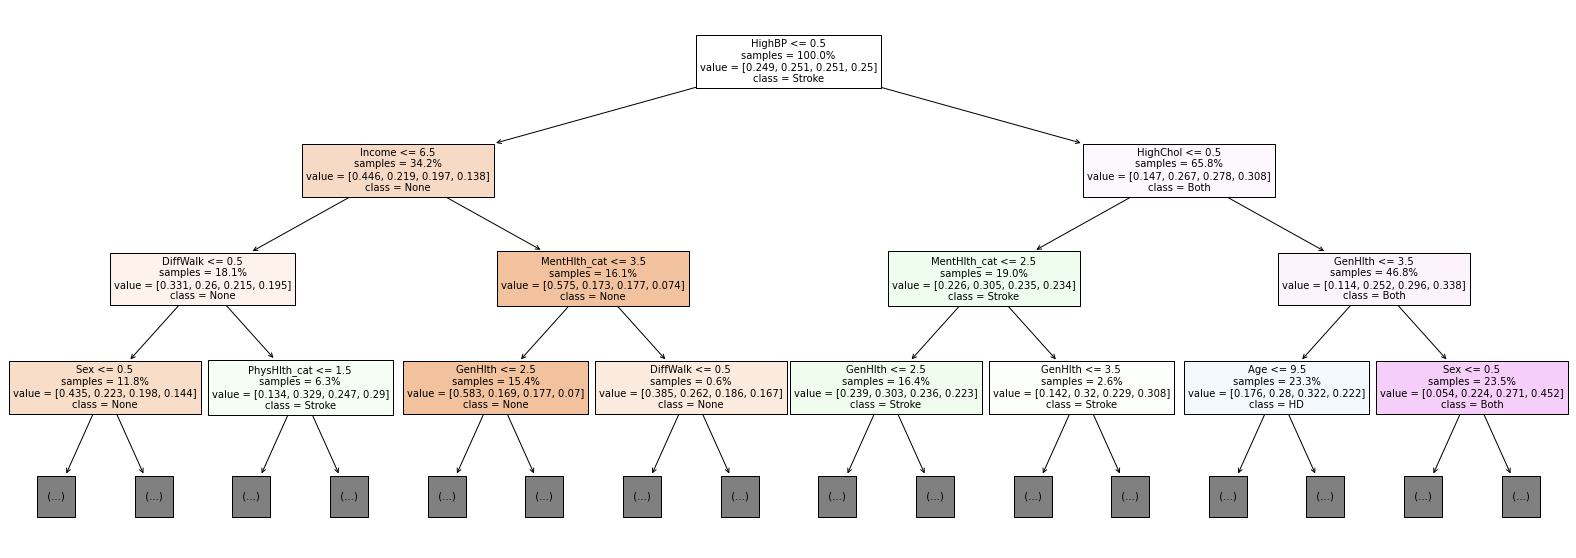

In [126]:
# HighBP -> HighChol -> GenHlth
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[5], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

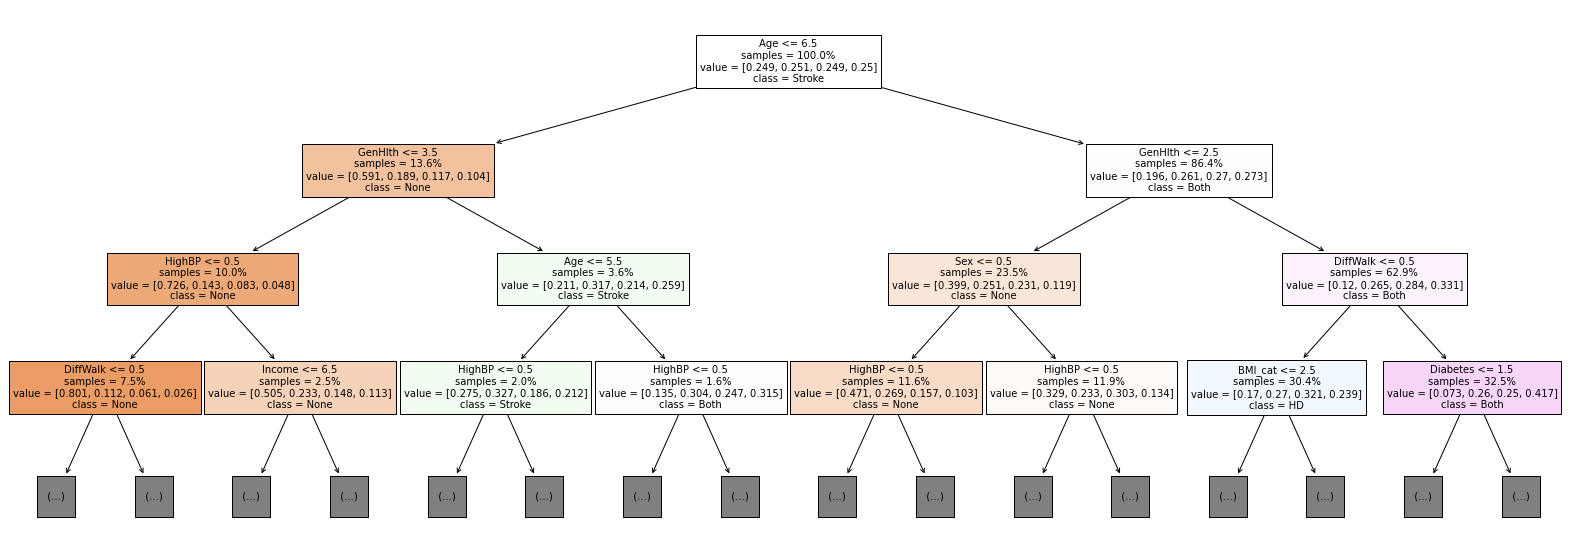

In [127]:
# Age -> Increase but small (likely because of cutoff)
# Age -> GenHlth 
# Age -> GenHlth -> DiffWalk
# HighBP <- GenHlth <- Age
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[6], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

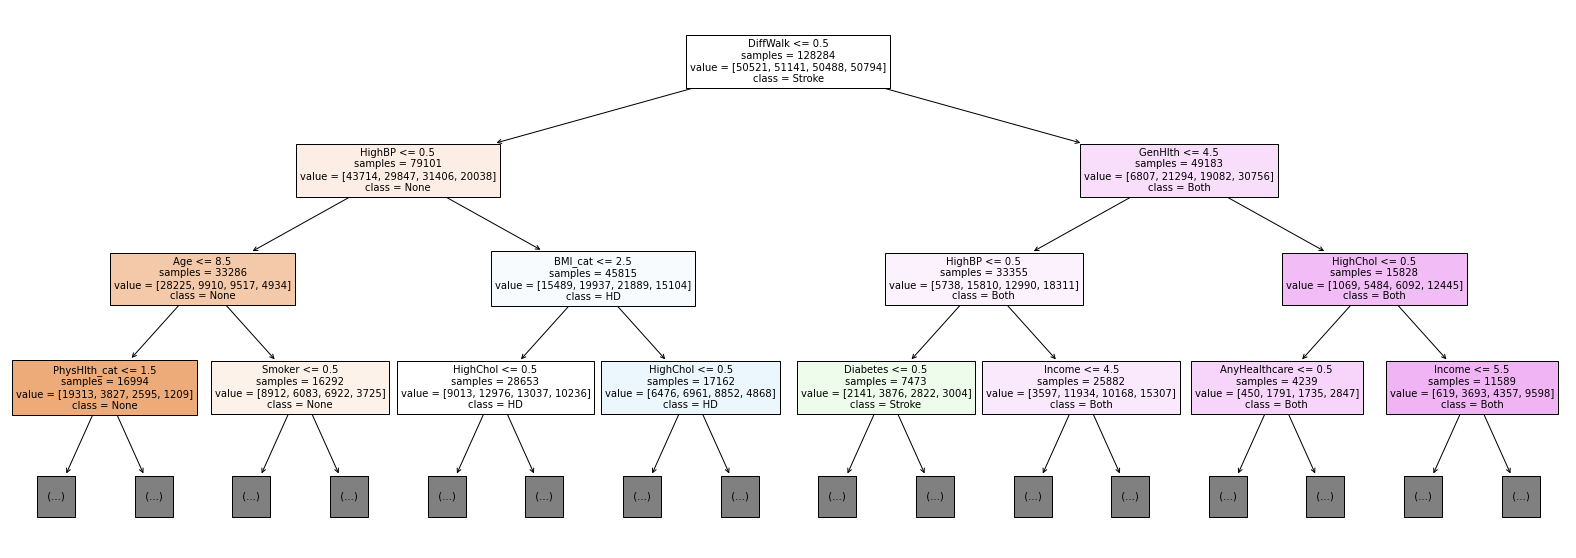

In [128]:
# DiffWalk -> GenHlth -> HighChol
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[8], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=False)
plt.show()

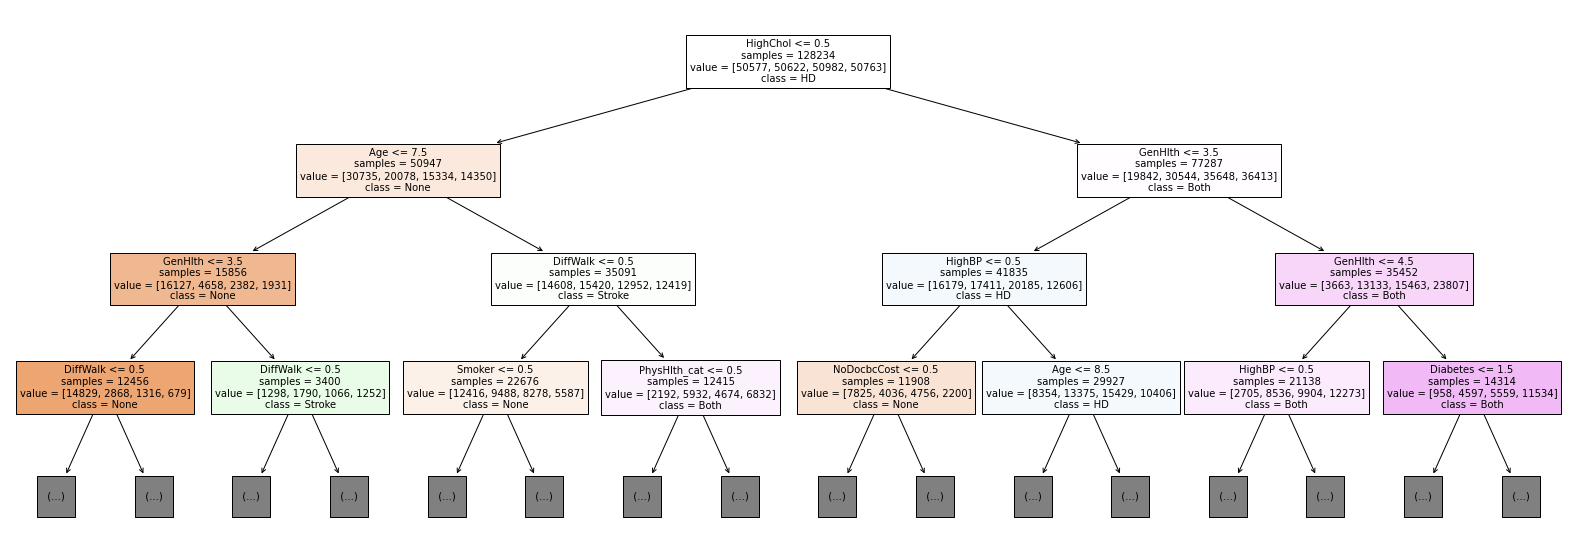

In [129]:
# HighChol -> GenHlth -> GenHlth
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[10], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=False)
plt.show()

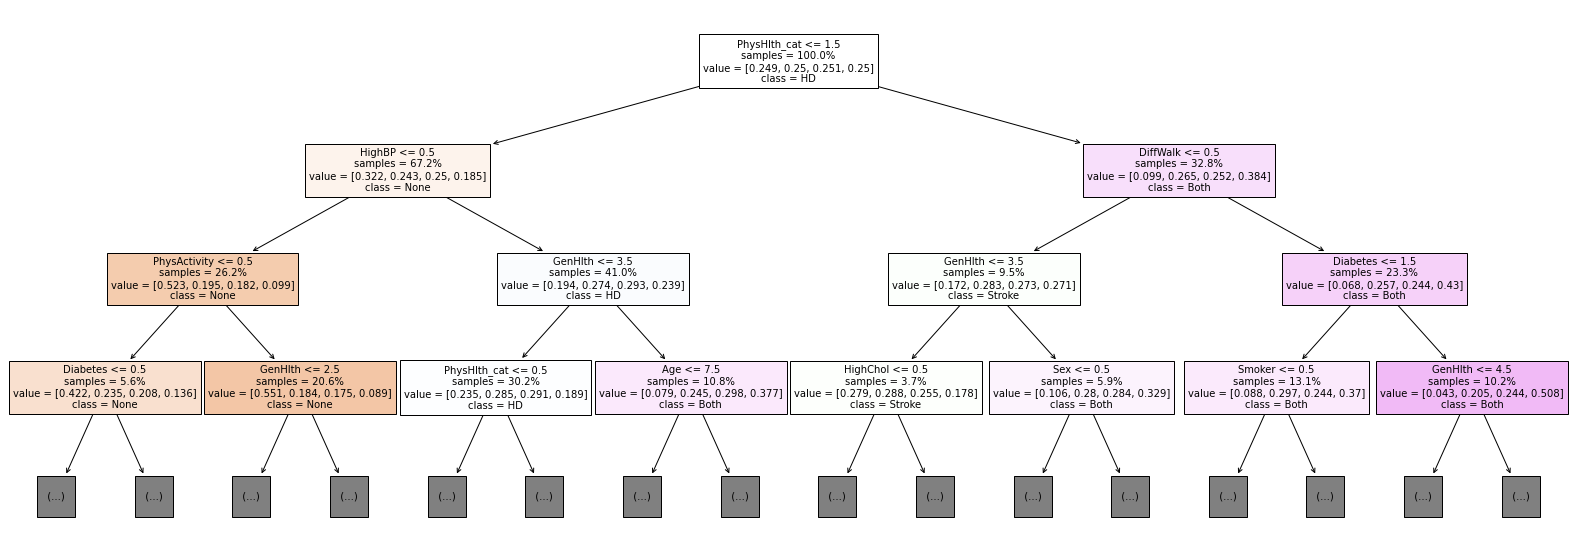

In [130]:
# We missed PhysHlth_cat -> DiffWalk -> Diabetes
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[11], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

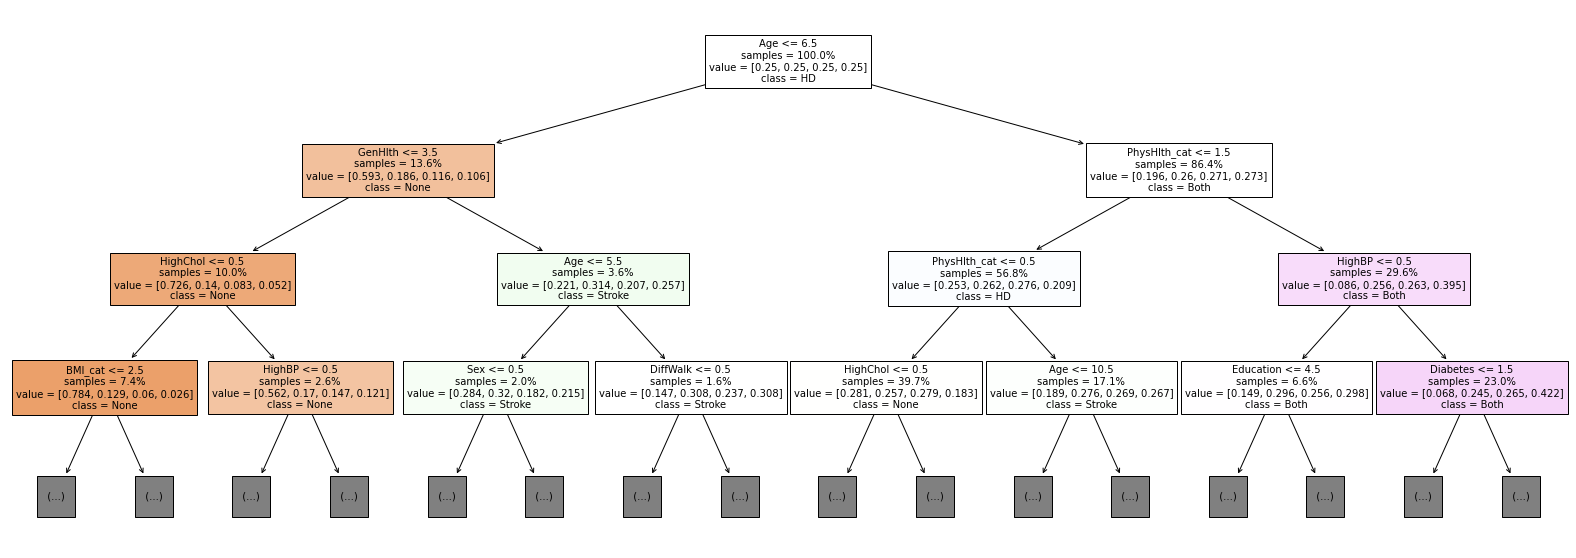

In [132]:
# Age <- GenHlth <- HighChol
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[15], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

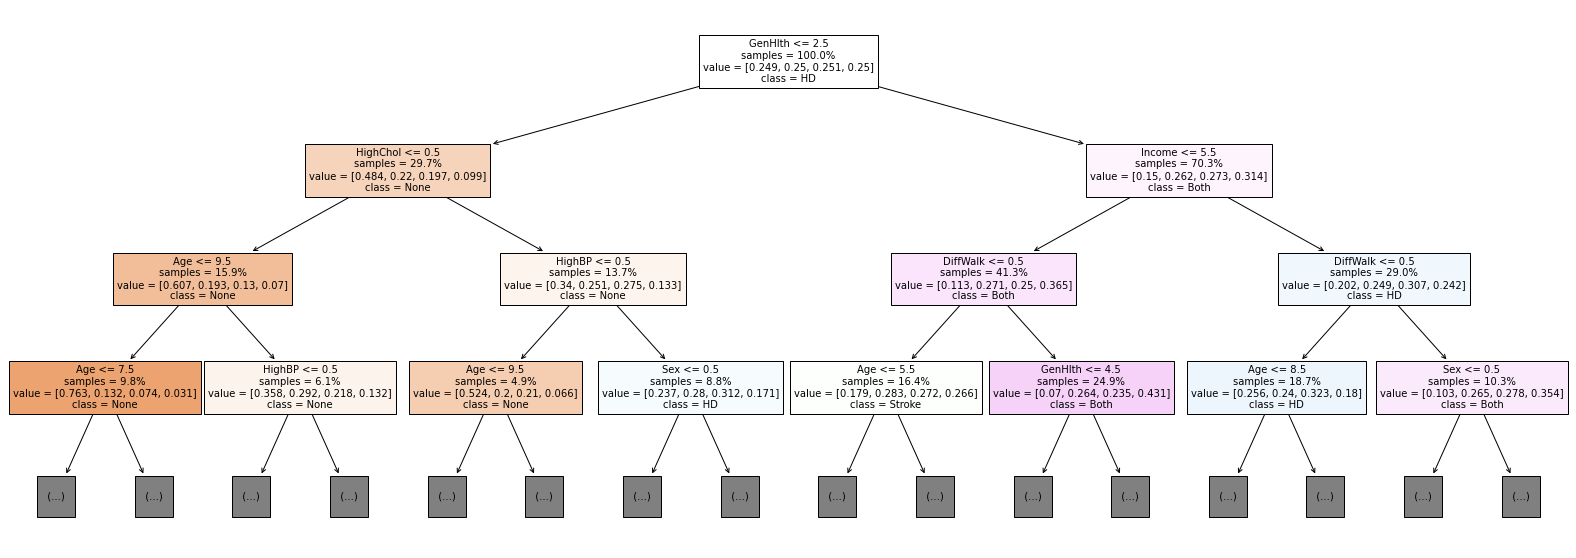

In [133]:
# Age <- HighChol <- GenHlth
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[19], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

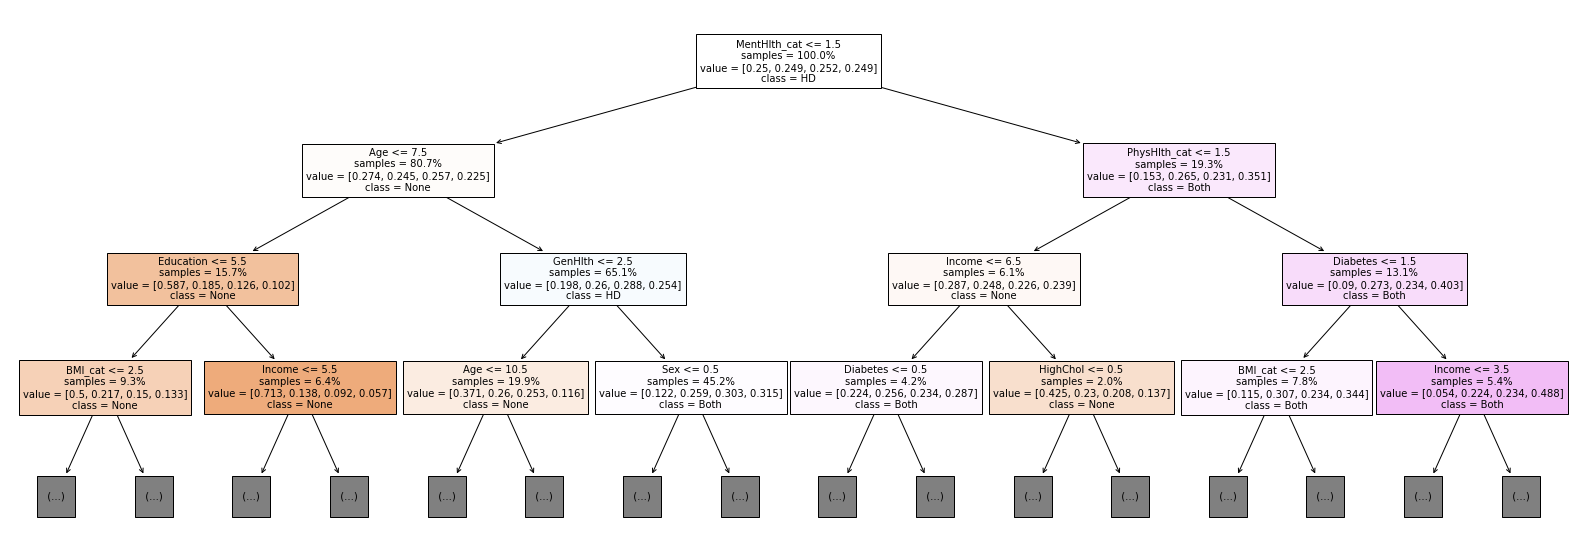

In [134]:
# We missed MentHlth_cat -> PhysHlth_cat -> Diabetes
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[20], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

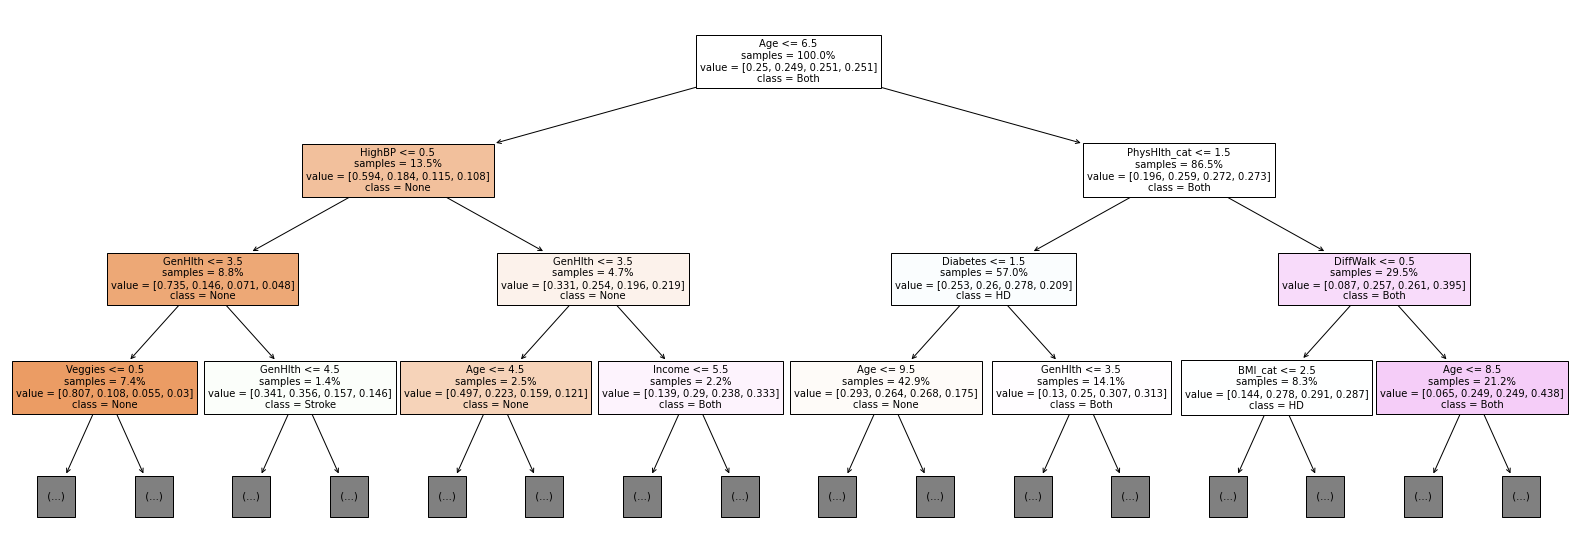

In [135]:
# GenHlth <- HighBP <- Age
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[23], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

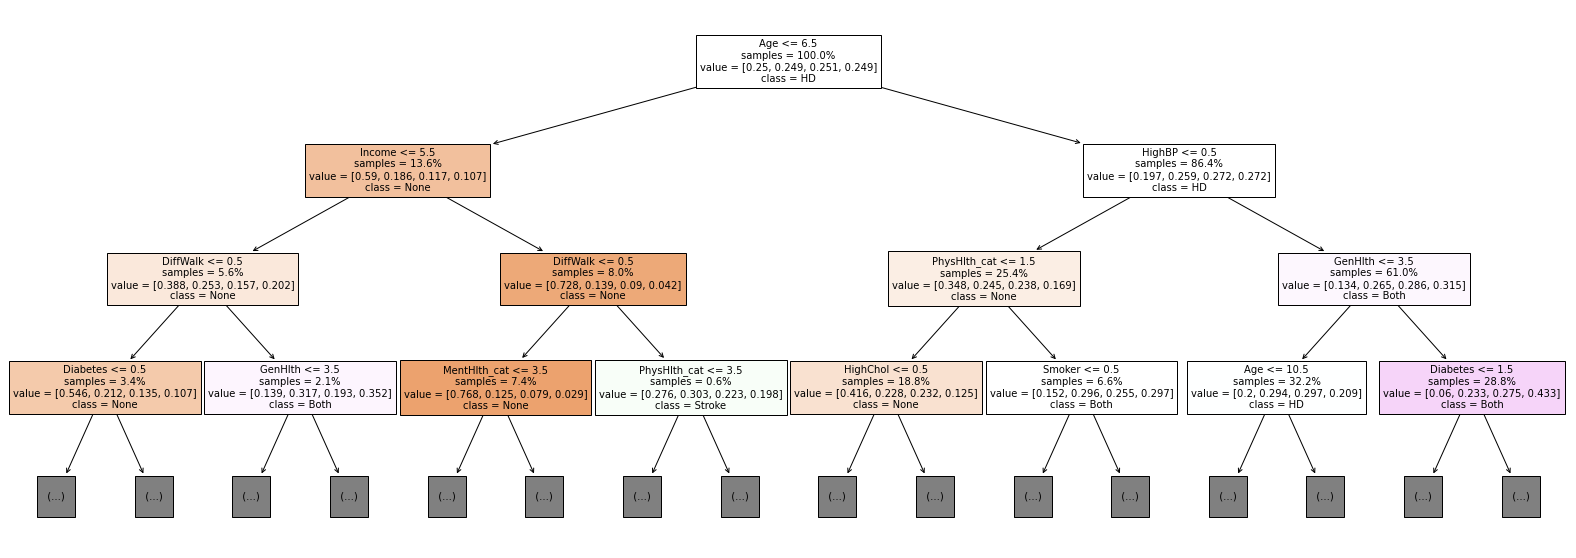

In [136]:
# Age -> HighBP -> GenHlth
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[24], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

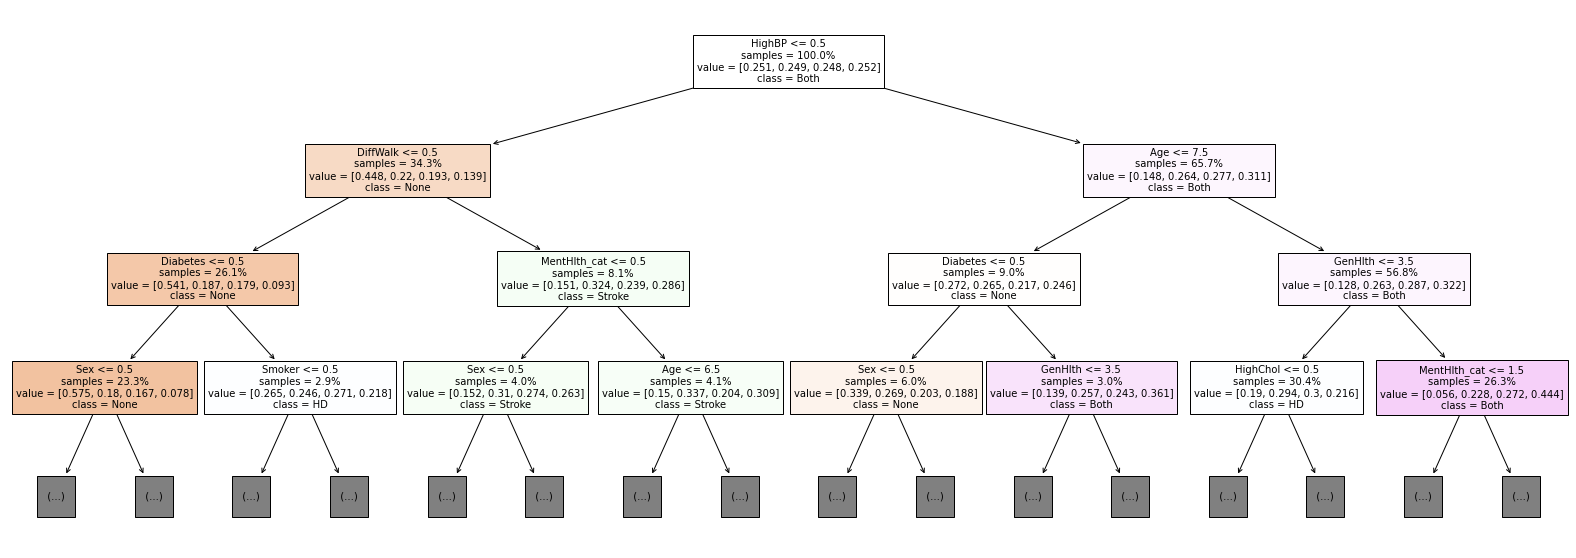

In [137]:
# HighBP -> Age -> GenHlth
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[31], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

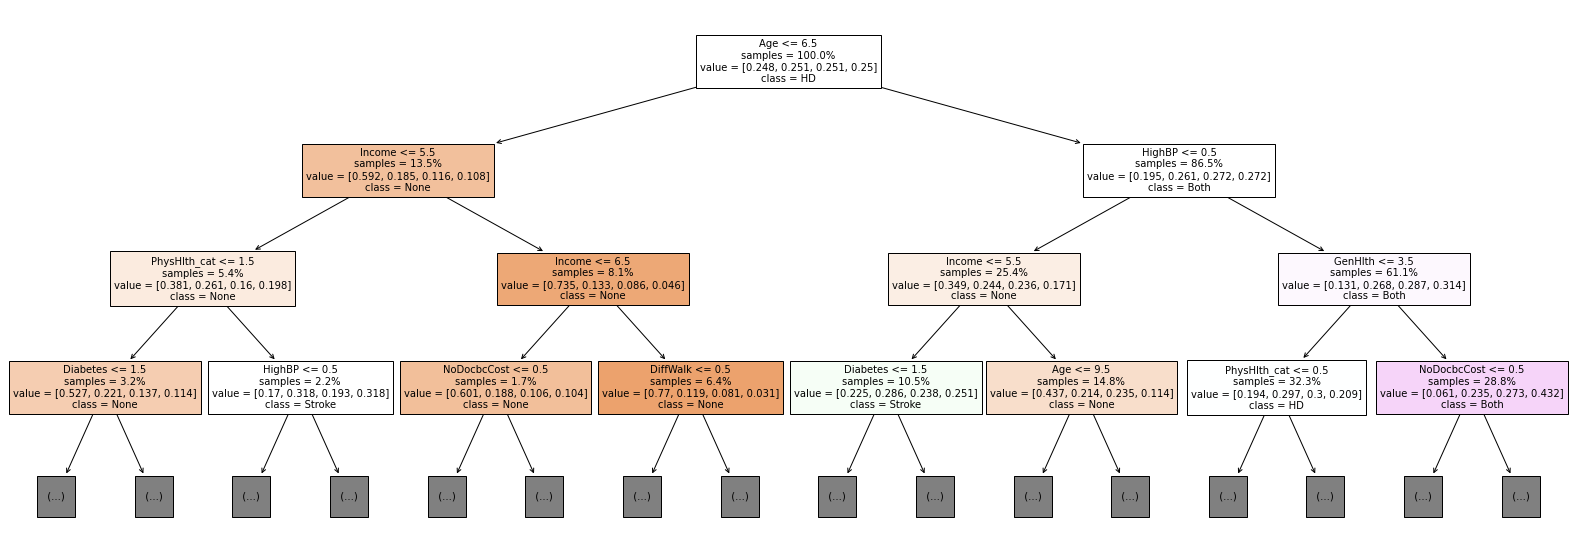

In [138]:
# Age -> HighBP -> GenHlth
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[33], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

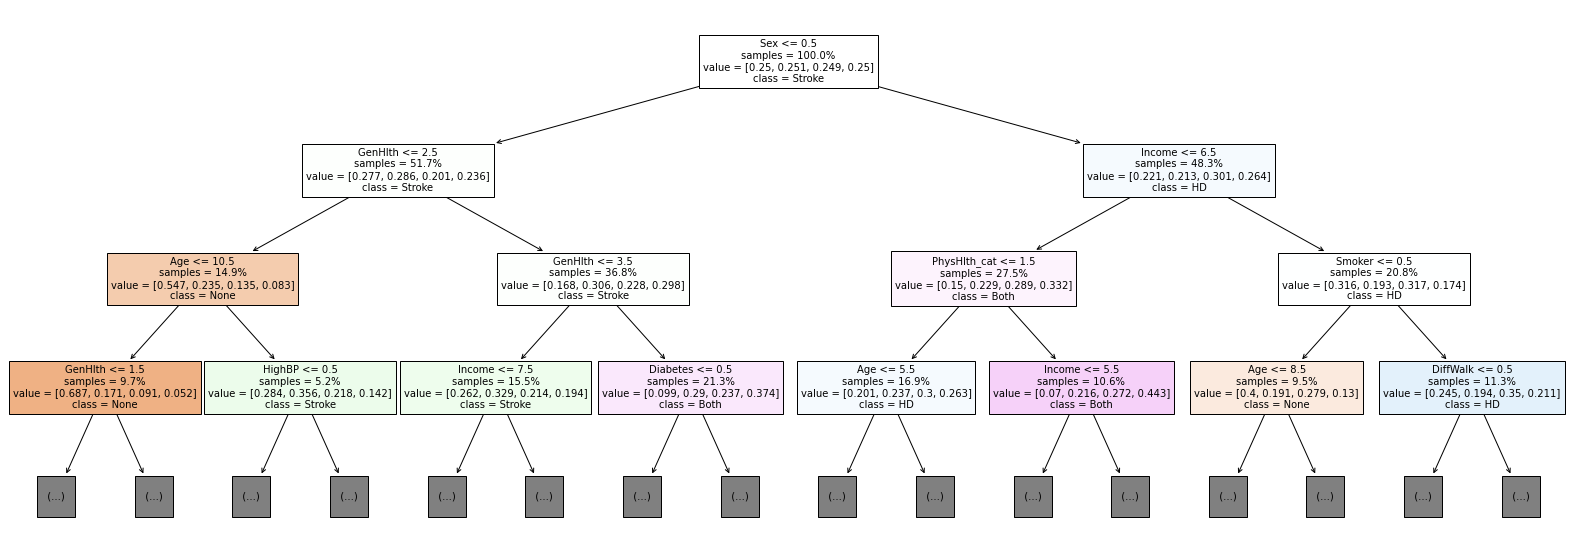

In [139]:
# Age <- GenHlth <- Sex
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[41], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

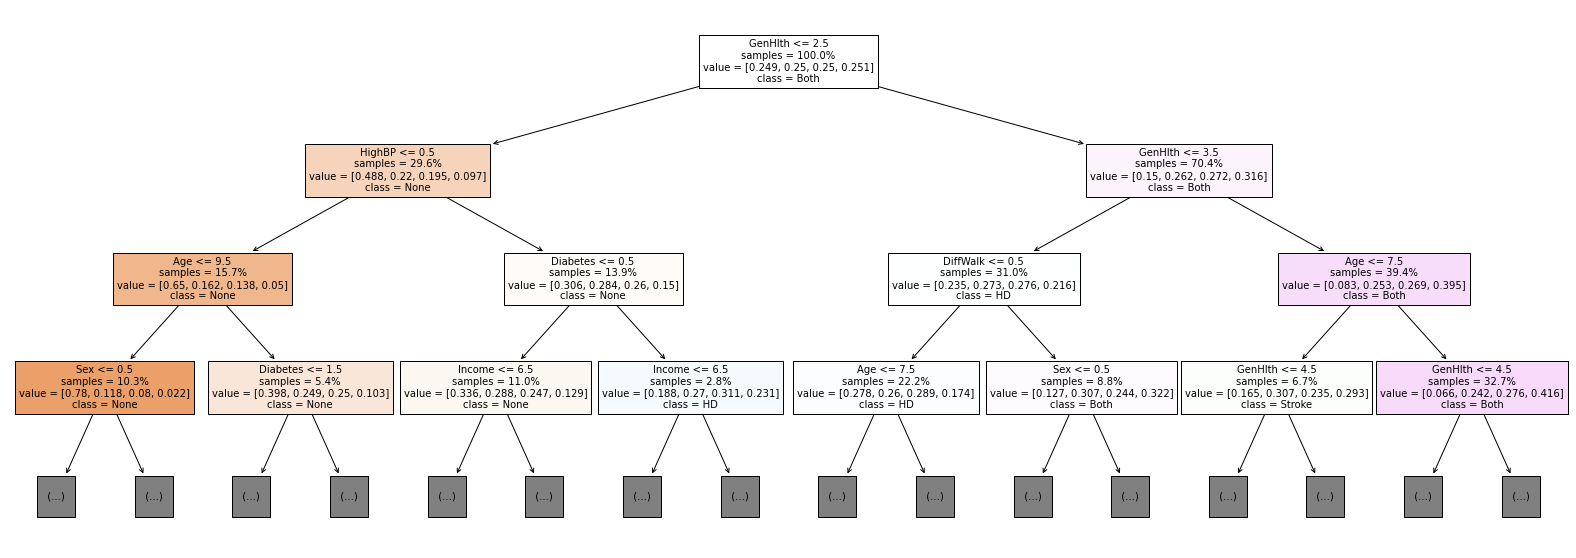

In [140]:
# GenHlth -> GenHlth -> Age
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[43], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

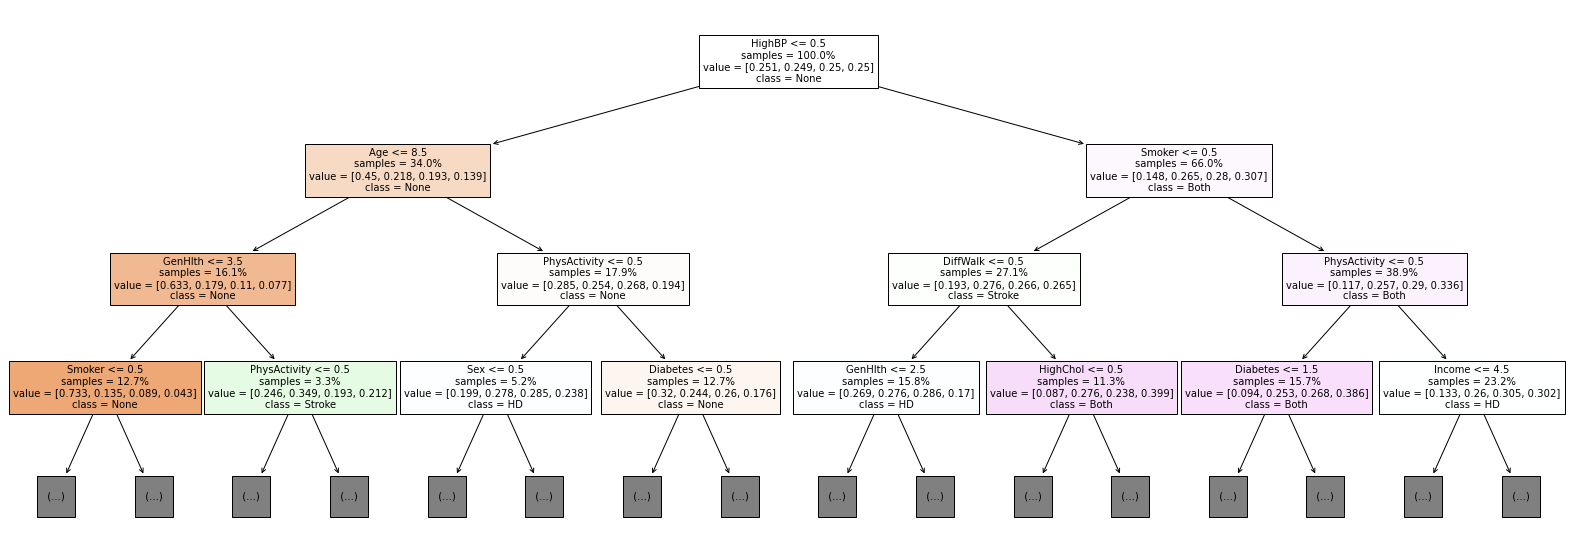

In [141]:
# GenHlth <- Age <- HighBP
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[55], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

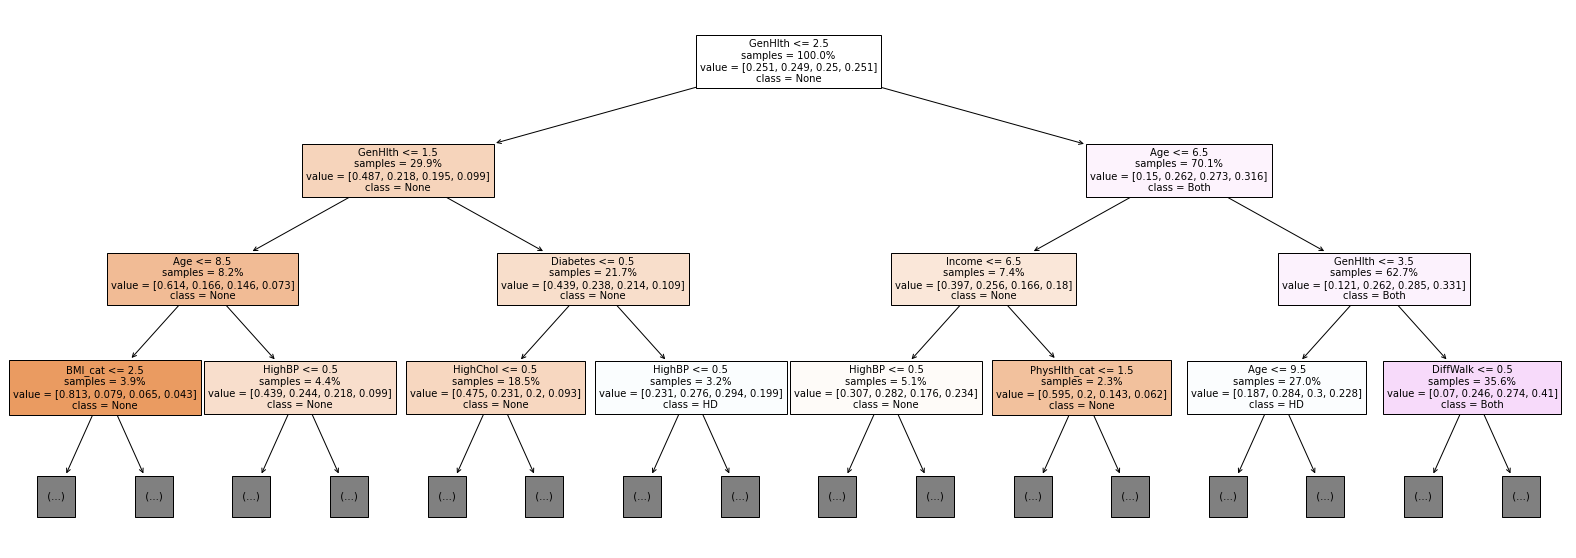

In [142]:
# GenHlth -> Age -> GenHlth
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[57], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=True)
plt.show()

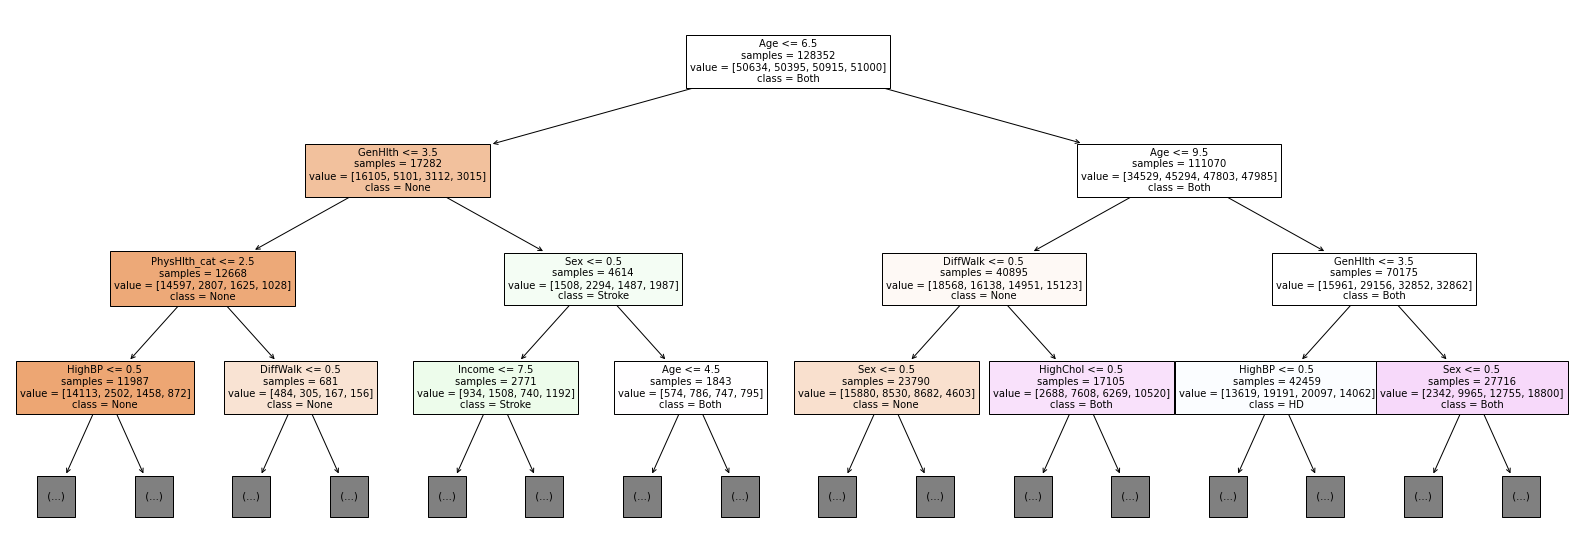

In [143]:
# Age -> Age -> GenHlth
plt.figure(figsize=(28,10))
plot_tree(rfc.estimators_[67], 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          max_depth=3, 
          fontsize=10, 
          impurity=False,
          proportion=False)
plt.show()